# DSCI 552 Lecture 2 - Generalized Linear Models: Count Regression

## Today's Learning Goals

By the end of this lecture, you should be able to:

- Perform likelihood-based model selection through analysis of deviance, Akaike Information Criterion, and Bayesian Information Criterion.
- Build up another three fundamental generalized linear models (GLMs): Poisson, Quasi-Poisson, and Negative Binomial.
- Use count regression for prediction.

## Loading `R` Packages and Scripts

In [1]:
options(repr.matrix.max.rows = 6)
source("scripts/support_functions.R")
library(tidyverse)
library(broom)
library(glmbb)
library(AER)

── Attaching packages ─────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.0      ✔ stringr 1.4.0 
✔ readr   2.1.2      ✔ forcats 0.5.1 
── Conflicts ────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: survival



## 1. Likelihood-based Model Selection

In **DSCI 561**, you learned about **variable selection** in Ordinary Least-Squares (OLS) via specific metrics such as the  Akaike information criterion (AIC) and Bayesian information criterion (BIC). These metrics are also helpful tools to perform **model selection** in GLMs. Additionally, though we already discussed this fact for the Binary Logistic regression model, it is essential to highlight that **many** GLMs are estimated via maximum likelihood.

Having said all this, you will learn today that metrics such as AIC and BIC are likelihood-based. Hence, the concept of maximum likelihood estimation (MLE) will come into play again for model selection **in many GLMs (even OLS models!)**. Firstly, let us explore model selection for Binary Logistic regression via the dataset from [`lecture1`](https://pages.github.ubc.ca/MDS-2022-23/DSCI_562_regr-2_students/notes/lecture1_glm_logistic_regression.html).

### 1.1. The Breast Cancer Dataset

The data frame `breast_cancer` is the Wisconsin Diagnostic Breast Cancer dataset ([Mangasarian et al., 1995](http://ubc.summon.serialssolutions.com/2.0.0/link/0/eLvHCXMwlV1Nb9QwEB2xPSA4tHQLohRKDoDgsDSJndiRKlApVBx74PNk2bGDKui2jbf8Ff4uM46tbpZKFZdIO55NvNLLeLx-8waAla_z2UpMEAZXtlZKzllZGSk7WTBdtDa3ts6N61aoOnUqjSGWZaAJhkN9zJfML7dHCi-yfnt-MaPmUXTIGjtpTGAi2cDr-rKkvFsPbQwYBpyafxsvQMTDbPEOVxE5yQSH8iZKHH2iKv4TrsMadLQBKk03kU9WagPHAo___7vuwXpMT7ODAU-bcMvNp3A7seOnsJG6QGQxKEzh7pKk4RQ2o91nL6Oi9ast-LN_qvufb94RAX6xvxc-ZIPtkFDXj23vB_rfiR-b9dxmx_3ZdUO_T_TYgFtsfIXHtuOBinaK84wD9-Hz0YdPhx9nsSPEDPeBJWmp6pJ3VS1tzlvR8Ua6WljWlm3RaMkMs52R1jmJWGu4a6wwtugaaauGtQWaH8Da_GzuHkJWVlpwbgpthKOz3aZsmeRWC9mJxnG7DS8STNT5IPyhaMOEO0xF_WkUZ4qrSuTomEB0k-MzgpiK3UXx4un_F_9DX3qvDjCPw2yPMbxfcCPwLXrd6lgngdMmqa5lx6cJqyoiNTzQLz3xeRq4YWZbAYxXXgGJ27CT8K5iZPOqJEFAUnl8dP2XduDOUPVPjObHsLboL92TIGmxCxPx9TteMcDshnf0L2aRR50)). It has a **binary** response `target`: whether the tumour is `benign` or `malignant`.

Recall this dataset contains  569 observations from a digitized image of a fine needle aspirate (FNA) of a breast mass. The dataset details 30 real-valued characteristics (i.e., continuous regressors) plus the binary response and `ID` number. We will start working with the response `target` and the regressors `mean_radius` and `mean_texture`.

In [2]:
breast_cancer <- suppressWarnings(suppressMessages(read_csv("datasets/breast_cancer.csv")))

breast_cancer <- breast_cancer %>%
  dplyr::select(mean_radius, mean_texture, target)
breast_cancer

mean_radius,mean_texture,target
<dbl>,<dbl>,<chr>
17.99,10.38,malignant
20.57,17.77,malignant
19.69,21.25,malignant
⋮,⋮,⋮
16.60,28.08,malignant
20.60,29.33,malignant
7.76,24.54,benign


Mathematically, we to set the binary response $Y_i$  as:

$$
Y_i =
\begin{cases}
1 \; \; \; \; \mbox{if the $i$th tumour is malignant},\\
0 \; \; \; \; 	\mbox{otherwise.}
\end{cases}
$$

The "1" category is referred as **success**. Note each $Y_i$ is a **Bernoulli** trial whose **probability of success** is $\pi_i$, i.e., 

$$Y_i \sim \text{Bernoulli}(\pi_i).$$

Unlike [`lecture1`](https://pages.github.ubc.ca/MDS-2022-23/DSCI_562_regr-2_students/notes/lecture1_glm_logistic_regression.html#using-ordinary-least-squares-to-model-probabilities), we will not transform the levels in `target` as `1` for `malignant` and `0` for `benign`. The `glm()` function can work around the original level names **if we set up `target` as factor-type and the failure as the baseline**. 

Recall function `levels()` will tell us the baseline level, which is the one on the left-hand side. According to our previous mathematical setup for $Y_i$, level `benign` is the failure.

In [3]:
breast_cancer <- breast_cancer %>%
  mutate(target = as.factor(target))

levels(breast_cancer$target)

[1] "benign"    "malignant"

**To perform model selection**, let us estimate two Binary Logistic regression models with `target` as a response. **Model 1** will only have the continuous `mean_radius` ($X_{\texttt{mr}_i}$) as a regressor, whereas **Model 2** will have `mean_radius` and `mean_texture` ($X_{\texttt{mr}_i}$ and $X_{\texttt{mt}_i}$) as regressors.

```{math}
\begin{align*}
\textbf{Model 1:} & \\ 
& h(\pi_i) = \log\left(\frac{\pi_i}{1 - \pi_i}\right) = \beta_0 + \beta_1 X_{\texttt{mr}_i}. \\
\textbf{Model 2:} & \\ 
& h(\pi_i) = \log\left(\frac{\pi_i}{1 - \pi_i}\right) = \beta_0 + \beta_1 X_{\texttt{mr}_i} + \beta_2 X_{\texttt{mt}_i}. \\
\end{align*}
```

Then, via `glm()` and `breast_cancer`, we obtain our regression estimates.

In [4]:
binary_log_model_1 <- glm(as.factor(target) ~ mean_radius,
  data = breast_cancer, family = binomial
)

binary_log_model_2 <- glm(as.factor(target) ~ mean_radius + mean_texture,
  data = breast_cancer, family = binomial
)

Since we are digging into model selection, let us keep in mind the below **main statistical inquiry**.

```{admonition} Main statistical inquiry
We want to determine which Binary Logistic regression model fits the data better: **Model 1** or **Model 2**.
```

### 1.2. Analysis of Deviance

The **deviance** ($D_p$) criterion can be used to compare a given model with $p$ regressors with that of a **baseline model**. The usual baseline model is the **saturated** or **full model**, which perfectly fits the data because it allows a distinct probability of success $\pi_i$ for the $i$th observation in the dataset ($i = 1, \dots, n$), **unrelated to the $p$ regressors**.

The **maximized likelihood** of this full model is denoted as $\hat{\mathscr{l}}_f$. Now, let $\hat{\mathscr{l}}_p$ be the value of the maximized likelihood computed from our dataset of $n$ observation with $p$ regressors.

We can compare the fits provided by these two models by the deviance $D_p$ given by

$$
D_p = -2 \log \Bigg(\frac{\hat{\mathscr{l}}_p}{\hat{\mathscr{l}}_f} \Bigg) =  -2 \left[ \log \left( \hat{\mathscr{l}}_p \right) - \log \left( \hat{\mathscr{l}}_f \right) \right].
$$

Note that $D_p$ expresses **how much our given model deviates from the full model on log-likelihood scale**. This metric is interpreted as follows:

- **Large values** of $D_p$ arise when $\hat{\mathscr{l}}_p$ is small relative to $\hat{\mathscr{l}}_f$, indicating that **our given model fits the data poorly compared to the baseline model**.
- **Small values** of $D_p$ arise when $\hat{\mathscr{l}}_p$ is similar to $\hat{\mathscr{l}}_f$, indicating that **our given model provides a good fit to the data compared to the baseline model**.

**For the specific case of the Binary Logistic regression**, it can be shown that $D_p$ is represented by the following equation:

```{math}
:label: deviance-bin-log
\begin{equation}
D_p = -2 \sum_{i = 1}^n \big[\hat{\pi}_i \text{logit}(\hat{\pi}_i) + \log (1 - \hat{\pi}_i) \big],
\end{equation}
```

where $\hat{\pi}_i$ is the estimated probability of success for the $i$th observation for $i = 1, \dots, n$ in our random sample **with our fitted model of $p$ regressors**. Equation {eq}`deviance-bin-log` above comes from **maximum likelihood estimation**.

```{attention}
The mathematical proof for the previous equation can be checked in [Collett (2003)](https://www-taylorfrancis-com.ezproxy.library.ubc.ca/chapters/models-binary-binomial-data-david-collett/10.1201/b16654-6?context=ubx&refId=fa9f451b-9961-4928-99be-036c68551115) in Chapter 3 (Section 3.8.2). **This is optional material**.
```

```{caution} 
**For the specific case of Binary Logistic regression**, deviance $D_p$ cannot be used as a standalone metric of **goodness of fit** because of **data sparsity**; i.e., each $i$th observation has a different set of observed values for the $p$ regressors if at least one of them is of **continuous-type**. This data sparsity puts $D_p$ {eq}`deviance-bin-log` just in function of the fitted probabilities $\hat{pi}_i$ and not on the observed values $y_i$ (which tells us nothing about the agreement of our model with $p$ regressors to the observed data!).
```

Still, for the case of Binary Logistic regression, we can use the analysis of deviance to perform model selection **between two models where one is nested in the other** (as in this example for **Model 1** and **Model 2**). So we will use our two models: `binary_log_model_1` with `mean_radius` as a regressor, which is nested in `binary_log_model_2` with `mean_radius` and `mean_texture` as regressors.

This specific model selection will involve a hypothesis testing. The hypotheses are:

```{math}
\begin{gather*}
H_0: \textbf{Model 1} \text{ fits the data better than } \textbf{Model 2} \\
H_a: \text{otherwise.}
\end{gather*}
```

We have to use the multipurpose function `anova()` in the following way:

In [5]:
round(anova(binary_log_model_1,
  binary_log_model_2,
  test = "Chi"
), 4)

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,567,330.0108,NA,NA,NA
2,566,291.1233,1,38.8875,0


Let $D_2$ be the deviance (column `Resid. Dev`) for **Model 2** (`binary_log_model_2`) in row 2 and $D_1$ (column `Resid. Dev`) the deviance for **Model 1** (`binary_log_model_1`) in row 1. The test statistic $\Delta_D$ (column `Deviance`) for the analysis of deviance is given by:

$$
\Delta_D = D_1 - D_2 \sim \chi^2_{1},
$$

which **assymptotically** (i.e., $n \rightarrow \infty$) is Chi-squared distributed with $1$ degree of freedom (column `Df`) under $H_0$ **for this specific case**. In general, the degrees of freedom are the **regression parameters of difference between both models** (this has an impact on the factor-type explanatory variables with more than one dummy variable). Formally, this is called the **likelihood-ratio test**.

We obtain a $p\text{-value} < .001$, column `Pr(>Chi)`, which gives us evidence to reject $H_0$. Hence, **we do not have evidence** to conclude that `binary_log_model_1` fits the data better than `binary_log_model_2`. In the context of model selection, adding `mean_texture` provides a better fitted model. Hence, we would choose `binary_log_model_2`.

### 1.3. Akaike Information Criterion (AIC)

**One of the drawbacks of the analysis of deviance** is that it only allows to test **nested** regression models when we have sparse data (each response is associated with a different set of values in the regressors).

Fortunately, we have alternatives for model selection. **The AIC makes possible to compare models that are either nested or not.** For a model with $p$ model terms and a deviance $D_p$ is defined as:

```{math}
:label: aic
\begin{equation}
\mbox{AIC}_p = D_p + 2p.
\end{equation}
```

Models with **smaller** values of $\mbox{AIC}_p$ are preferred. $\mbox{AIC}_p$ favours models with small values of $D_p$.

```{attention}
However, $\mbox{AIC}_p$ penalizes for including more regressors in the model. Hence, it discourages overfitting, which is key in model selection. We select that model with the smallest $\mbox{AIC}_p$.
```

The function `glance()` shows us the $\mbox{AIC}_p$ by model.

In [6]:
glance(binary_log_model_1) %>% mutate_if(is.numeric, round, 3)

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
751.44,568,-165.005,334.011,342.699,330.011,567,569


In [7]:
glance(binary_log_model_2) %>% mutate_if(is.numeric, round, 3)

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
751.44,568,-145.562,297.123,310.155,291.123,566,569


Following the results of the `AIC` column, we choose `binary_log_model_2` over `binary_log_model_1`.

### 1.4. Bayesian Information Criterion (BIC)

An alternative to AIC is BIC. **The BIC also makes possible to compare models that are either nested or not.** For a model with $p$ regressors, $n$ observations used for fitting, and a deviance $D_p$ is defined as:

```{math}
:label: bic
\mbox{BIC}_p = D_p + p \log (n).
```

Models with **smaller** values of $\mbox{BIC}_p$ are preferred. $\mbox{BIC}_p$ also favours models with small values of $D_p$.

```{attention}
The differences between AIC and BIC will be more pronounced in datasets with large sample sizes $n$. As the BIC penalty of $p \log (n)$ will always be larger than the AIC penalty of $2p$ when $n > 7$, **BIC tends to select models with fewer regressors than AIC**.
```

Following the results of the `BIC` column above, we also choose `binary_log_model_2` over `binary_log_model_1` (column `BIC`).

## 2. Poisson Regression

It is time to move on to another GLM framework: **count regression**. As its name says, this class of modelling addresses count-type responses (i.e., integers). As in any other GLM, there will be a **link function** which will allow us **to relate the systematic component with the response's mean**. Moreover, there is more than one approach in count regression: **Poisson**, **Quasi-Poisson**, and **Negative Binomial**. Poisson regression is the first one we should use when handling a count response.

### 2.1. The Crabs Dataset

The data frame `crabs` ([Brockmann, 1996](https://ubc.summon.serialssolutions.com/2.0.0/link/0/eLvHCXMwrV3JasMwEBUlpZBLl7Sl6YY_oE4sy5sgFEpICKU9NadcjFYSmtghCyRf0t-tJC_EPhRaepMHS8jSSPM0M3oGALkdx67tCYRyKV0GacCp9CBX60RCySMcYiigy2qpOq_F1ZiMLqL0v-mFYrZvvd4JXXcPEnOUZbU1z6W-fxdoh6eO-XQUvDyGCnXrbK_hxCkDDCHKgs9KH20FelDOR_pzWxXbdYhljTEanoF10e8iC6V2SbDK9Pg_H3gOTnPsar1kynYBjkTSAs1yC923wMkkNaVL8NVbkNXn8wcxjJ8b0euaZysTvyuzVJUYH9i6Kpsl1ijVOSbTtPZ2f6V6nYuectnbbLGdb2tNLNP5fjkVi1J-BcbDwbg_svOfQNhMIRdsu4KHEnIsIiQYJoGQvsKQmAuOsE8lojRnrPEIlZQHHIUEEs8PBVHQjaJr0EjSRNwAS8ebmMNk4DHkRYgQSt2ARoxRnzuhJG2AitmNlxnVR3x4REI41sMf6-GP8-GPd20QmVn7RZV4MB7p0u3fq96BZpY-rn1B96CxWW3FgyGOeDR6_g1rIQSN)) is a dataset detailing the **counts of satellite male crabs** residing around a female crab nest. The code below renames the original response's name, `satell`, to `n_males`.

In [8]:
data(crabs)
crabs <- crabs %>%
  rename(n_males = satell) %>%
  dplyr::select(-y)
crabs

color,spine,width,n_males,weight
<fct>,<fct>,<dbl>,<int>,<int>
medium,bad,28.3,8,3050
dark,bad,22.5,0,1550
light,good,26.0,9,2300
⋮,⋮,⋮,⋮,⋮
light,good,28.0,0,2625
darker,bad,27.0,0,2625
medium,middle,24.5,0,2000


```{note}
The data frame `crabs` contains 173 observations on horseshoe crabs (Limulus polyphemus). The response is the count of male crabs (`n_males`) around a female breeding nest. It is subject to four explanatory variables: `color` of the prosoma with four levels (nominal factor-type), the condition of the posterior `spine` with three levels (nominal factor-type), the continuous variables carapace `width` (mm), and `weight` (g).
```

```{admonition} Main statistical inquiry
Let us suppose we want to assess whether `n_males` and `width` are statistically associated and by how much.
```

### 2.2. Exploratory Data Analysis

Before getting into any estimation and inference, performing the corresponding exploratory data analysis (EDA) is necessary. Therefore, we will make a scatterplot of `n_males` versus carapace `width` (see below), **even though `n_males` is not continuous**. **Note the characteristic horizontal pattern in the points below since the $y$-axis has repeated counts associated with different `width` values**. This plot pattern paves the way for using a count regression model. 

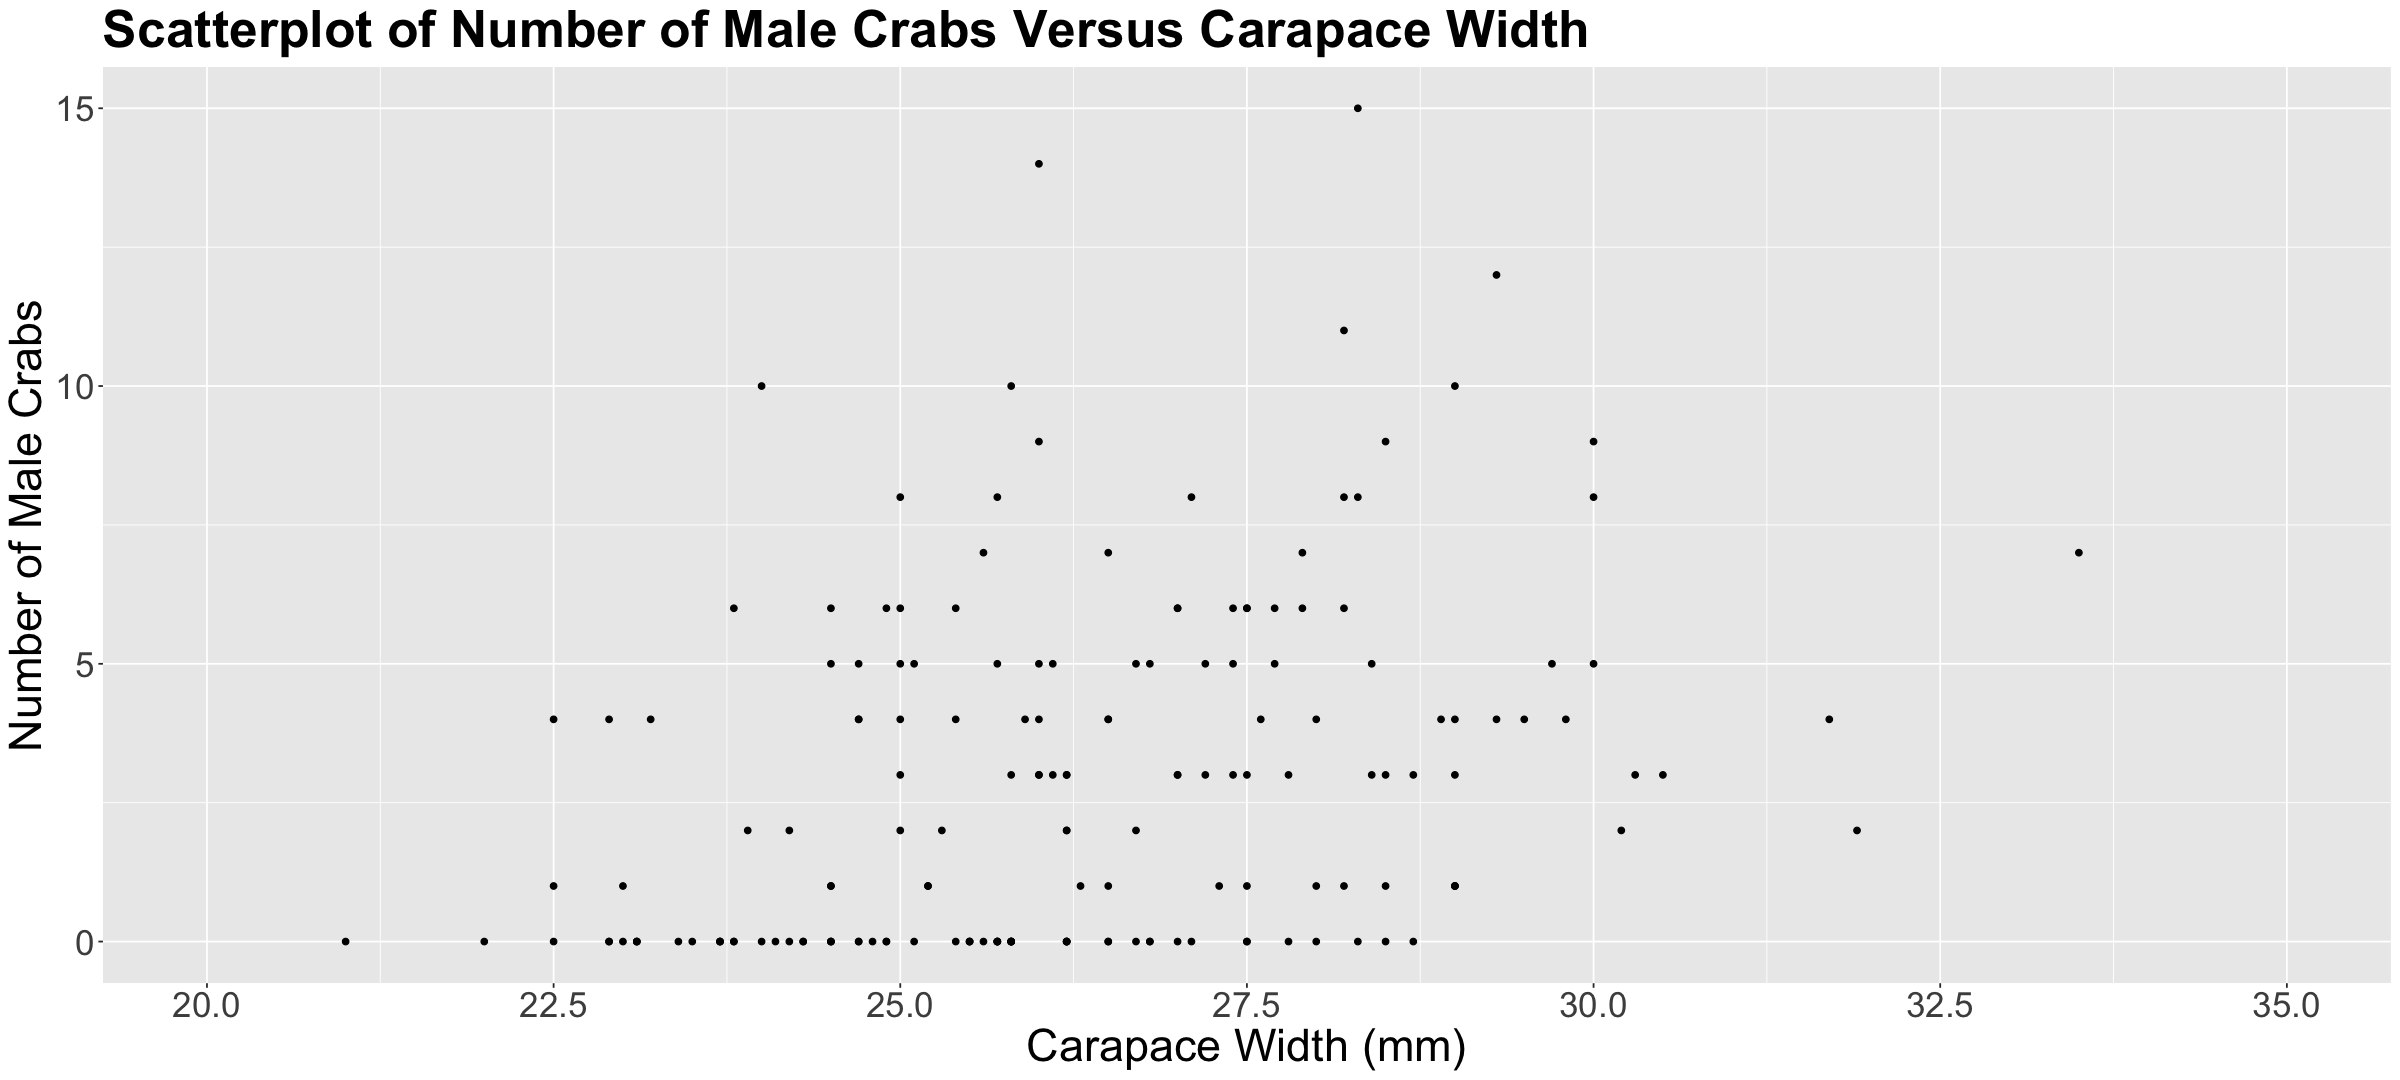

In [9]:
options(repr.plot.height = 9, repr.plot.width = 20)
plot_crabs_vs_width <- crabs %>%
  ggplot() +
  geom_point(aes(width, n_males)) +
  labs(y = "Number of Male Crabs", x = "Carapace Width (mm)") +
  ggtitle("Scatterplot of Number of Male Crabs Versus Carapace Width") +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27)
  ) +
  scale_x_continuous(limits = c(20, 35), breaks = seq(0, 35, by = 2.5))
plot_crabs_vs_width

**Do you think `n_males` increases with the carapace `width`?** It is pretty tricky to tell with this particular point pattern! 

Since the scatterplot above is too hard to visualize, let us make a clever visualization. Firstly, we could calculate the average `n_males` using a few carapace `width` groups.

In [10]:
group_avg_width <- crabs %>% 
  mutate(intervals = cut(crabs$width, breaks=10)) %>% 
  group_by(intervals) %>% 
  summarise(mean = mean(n_males), n = n()) 
group_avg_width

intervals,mean,n
<fct>,<dbl>,<int>
"(21,22.2]",0.000000,2
"(22.2,23.5]",1.000000,14
"(23.5,24.8]",1.769231,26
⋮,⋮,⋮
"(29.8,31]",4.857143,7
"(31,32.2]",3.000000,2
"(32.2,33.5]",7.000000,1


Then, we create another scatterplot using these `n_males` averages by `width` bins (as shown in the code below). Now it is easier to visualize and state, **descriptively**, that there is a positive relationship between carapace `width` and `n_males`. 

```{caution}
Nevertheless, we need to find a suitable regression model to statistically confirm this descriptive conclusion!
```

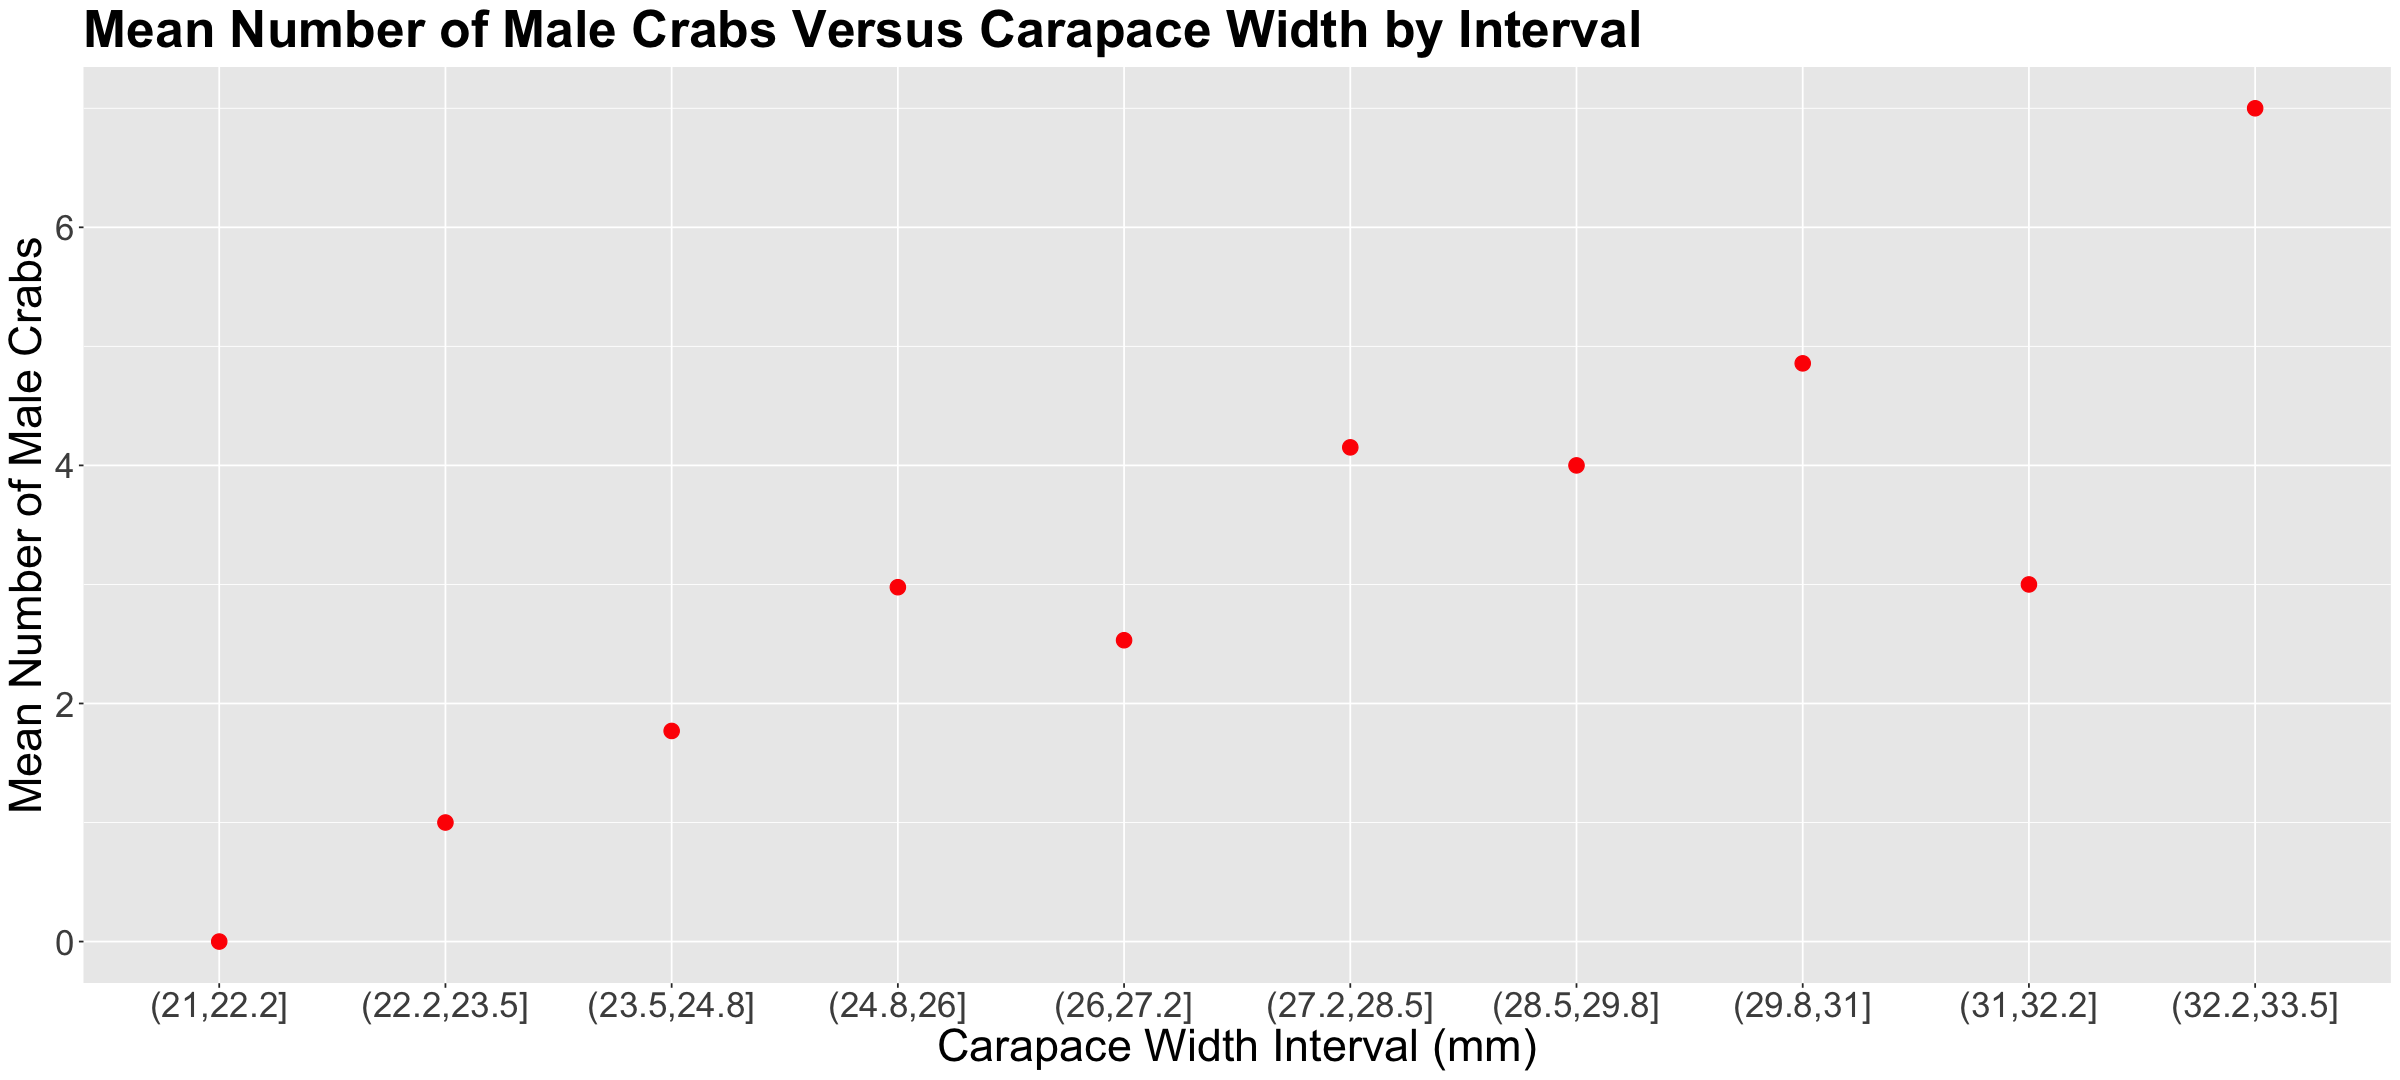

In [11]:
crabs_avg_width_plot <- group_avg_width %>%
  ggplot() +
  geom_point(aes(intervals, mean), colour = "red", size = 4) +
  labs(y = "Mean Number of Male Crabs", x = "Carapace Width Interval (mm)") +
  ggtitle("Mean Number of Male Crabs Versus Carapace Width by Interval") +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27)
  )
crabs_avg_width_plot

Given that `n_males` is a count-type response, a more appropriate standalone plot is a **bar chart** (as shown in the code below). This bar chart is giving us visual evidence of a possible **Poisson random variable**, note the **right-skewness**.

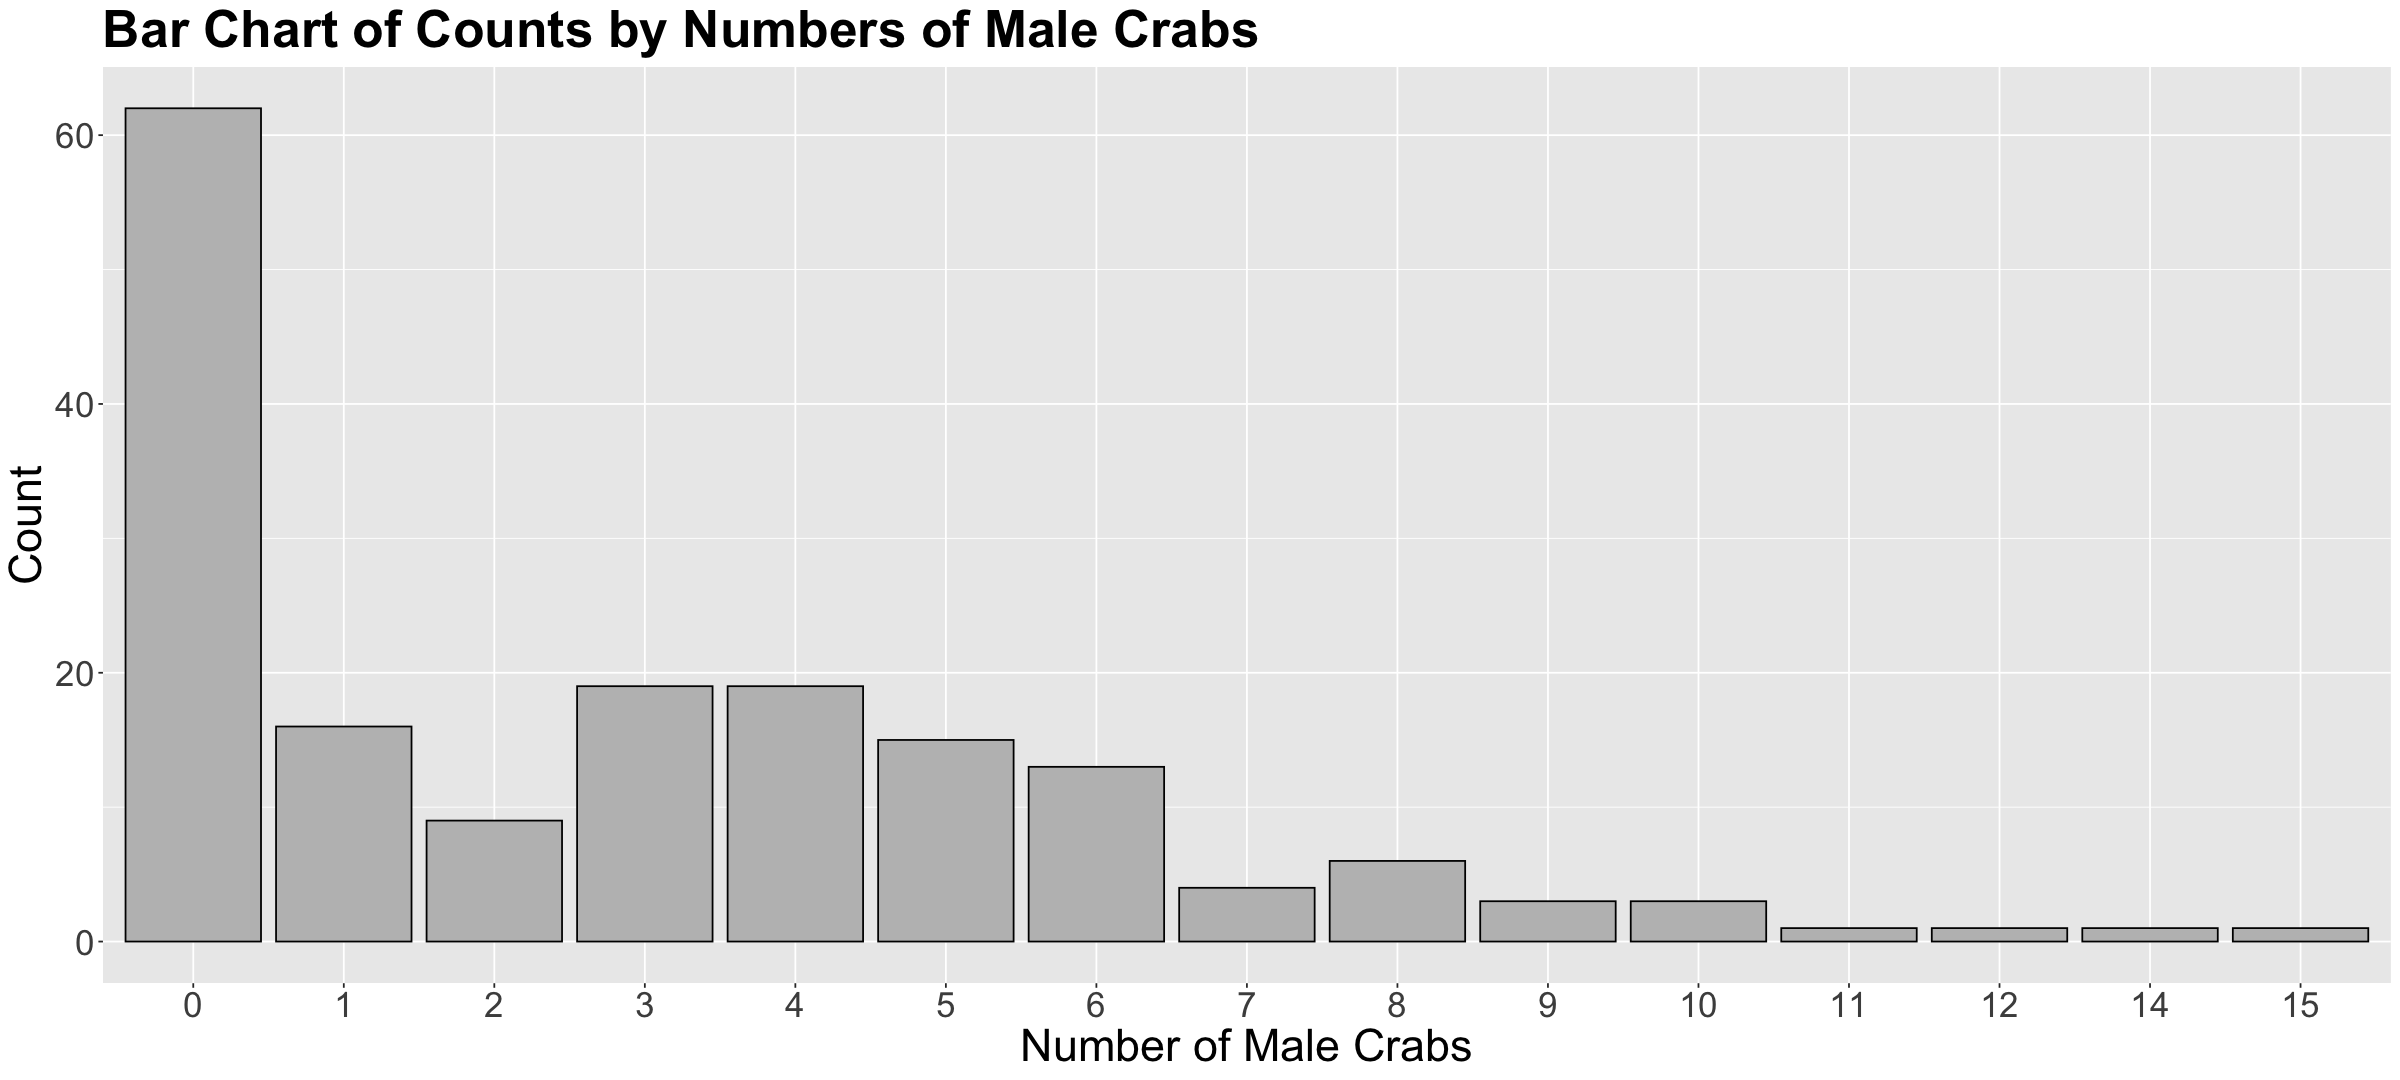

In [12]:
crabs_avg_width_bar_chart <- crabs %>%
  ggplot() +
  geom_bar(aes(as.factor(n_males)), fill = "grey", color = "black") +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27)
  ) +
  ggtitle("Bar Chart of Counts by Numbers of Male Crabs") +
  labs(x = "Number of Male Crabs", y = "Count")
crabs_avg_width_bar_chart

```{attention}
The distribution of the counts in the response `n_males` is suggesting a possible Poisson distribution. Hence we might use Poisson regression to assess whether carapace `width` is related to `n_males` and quantify the magnitude of the regressor's association (as well as the respective uncertainty associated with its estimation).
```

### 2.3. General Modelling Framework

Besides OLS and Binary Logistic regressions, another alternative is count data modelling, as in Poisson regression. Unlike Binary Logistic regression, **we use counts as a response variable**. Hence, we have to modify the framework to consider this fact. Poisson regression would be the primary resource when it comes to modelling counts. This model also fits into the GLM class. 

Recall that the residual component in the OLS regression model, namely $\varepsilon_i$, is assumed to be Normal, making the response $Y_i$ Normal. Therefore, **what is the distributional key difference between the Poisson and the OLS regression models in terms of the response?** First of all, we have to specify what a Poisson random variable is. Recall **DSCI 551**, a Poisson random variable refers to discrete data with non-negative integer values that count something. **These counts could happen during a given timeframe or even a space such as a geographic unit!** 

```{attention}
A particularity of a Poisson random variable is that its mean equals its variance (an inconsistency in **Dimensional Analysis**!). Thus, any factor that affects the mean will also affect the variance. This fact could be a potential drawback for using a Poisson regression model. Nonetheless, an alternative count modelling option could overcome this potential issue, which we will explain further.
```

The Poisson regression model assumes a random sample of $n$ count observations $Y_i$s, hence **independent** (**but not identically distributed!**), which have the following distribution:

$$Y_i \sim \text{Poisson}(\lambda_i)$$

Each $i$th observation has its own $\mathbb{E}(Y_i) = \lambda_i > 0$, which also implicates $\text{Var}(Y_i) = \lambda_i > 0$.

```{important}
The equality of the expected value and variance in a random variable is called **equidispersion**.
```

Parameter $\lambda_i$ is the risk of an event occurrence, coming from the definition of the Poisson random variable, in a given timeframe or even a space. 

```{important}
We have to highlight another particularity in this distribution: **$\lambda_i$ is continuous!**
```

For our `crabs` dataset, the events are the number of male crabs (`n_males`) around a space: **the female breeding nest**. Since we want to make inference on whether the carapace `width` is related to the response `n_males`, then we could use Poisson regression.

Since the Poisson Regression model is also a GLM, we need to set up a **link function $h(\lambda_i)$** for the mean.

Let $X_{\texttt{width}_i}$ be the $i$th value for the regressor `width` in our dataset. An easy modelling solution would be an **identity** link function as in 

$$
h(\lambda_i) = \lambda_i = \beta_0 + \beta_1 X_{\texttt{width}_i}.
$$

However, again, **we have a response range issue!**

The model above for $h(\lambda_i)$ has a significant drawback: **the right-hand side is allowed to take on even negative values**, which does not align with the nature of the parameter $\lambda_i$ (**that always has to be non-negative**). Recall the essential characteristic of a GLM that should come into play for a link function. In this class of models, the direct relationship between the original response and the regressors may be **non-linear** in $h(\lambda_i)$. Hence, instead of using the identity link function $\lambda_i$, **we will use the natural logarithm of the mean$: \log(\lambda_i)$**.

Before continuing with the `crabs` dataset, let us generalize the Poisson regression model with $p$ regressors as:

```{math}
:label: poisson-model
\begin{equation*}
h(\lambda_i) = \log(\lambda_i) = \beta_0 + \beta_1 X_{i,1} + \dots + \beta_p X_{i,p}.
\end{equation*}
```

In model {eq}`poisson-model`, each one of the $p$ regression coefficients $\beta_{1}, \dots, \beta_{p}$ represents **the expected change in the natural logarithm of the mean $\lambda_i$ per unit change in their respective regressors $X_{i,1}, \dots, X_{i,p}$**. Nonetheless, we could make more sense in the interpretation by exponentiating {eq}`poisson-model`:

$$
\lambda_i = \exp{(\beta_0 + \beta_1 X_{i,1} + \dots + \beta_p X_{i,p})},
$$

where an increase in one unit in any of the $p$ regressors (**while keeping the rest of them constant**) **multiplies the mean $\lambda_i$ by a factor $\exp{(\beta_j)}$, for all $j = 1, \dots, p$**.

In the `crabs` dataset with `width` as a regressor, the Poisson regression model is depicted as:

$$
h(\lambda_i) = \log(\lambda_i) = \beta_0 + \beta_1 X_{\texttt{width}_i}.
$$

As a side note, we have to clarify that the **systematic component** in the Poisson regression model is explicitly depicted by the regressors and their coefficients as in multiple linear regression. The **random component** is implicitly contained in each random variable 

$$Y_i \sim \text{Poisson}(\lambda_i).$$

### 2.4. Estimation

Under a general framework with $p$ regressors, the **regression parameters** $\beta_0, \beta_1, \dots, \beta_p$ in the model are also unknown. In order to estimate them, we will use function `glm()` and its argument `family = poisson` (required to specify the Poisson nature of the response), which obtains the estimates $\hat{\beta}_0, \hat{\beta}_1, \dots \hat{\beta}_p$.

The estimates are obtained through **maximum likelihood** where we assume a **Poisson joint probability mass function** of the $n$ responses $Y_i$.

```{attention}
For the sake of coding clarity, you could also use `family = poisson(link = "log")`. Nevertheless, `link = "log"` is a default in `glm()` for Poisson regression. Thus, `family = poisson` suffices when using the logarithmic function.
```

In [13]:
poisson_model_1 <- glm(n_males ~ width, family = poisson, data = crabs)

### 2.5. Inference

**The fitted regression model will be used to identify the relationship between the logarithm of the response's mean and regressors.** To determine the **statistical significance** of $\beta_j$ in this model, we also use the **Wald statistic $z_j$**:

$$
z_j = \frac{\hat{\beta}_j}{\mbox{se}(\hat{\beta}_j)}
$$

to test the hypotheses

```{math}
\begin{gather*}
H_0: \beta_j = 0 \\
H_a: \beta_j \neq 0;
\end{gather*}
```

where the **null hypothesis** $H_0$ indicates that the $j$th regressor associated to $\beta_j$ does not have any association on the response variable in the model, and the **alternative hypothesis** $H_a$ otherwise.

`R` provides the corresponding **$p$-values** for each $\beta_j$. The smaller the $p$-value, the stronger the evidence against the null hypothesis $H_0$. As in the previous regression models, we would set a predetermined significance level $\alpha$ to infer if the $p$-value is small enough. If the $p$-value is smaller than the predetermined level $\alpha$, then we could claim that there is evidence to reject the null hypothesis. Hence, $p$-values that are small enough indicate that the data provides evidence in favour of **association** (**or causation in the case of an experimental study!**) between the response variable and the $j$th regressor.

Furthermore, given a specified level of confidence where $\alpha$ is the significance level, we can construct approximate $(1 - \alpha) \times 100\%$ **confidence intervals** for the corresponding true value of $\beta_j$:

$$
\hat{\beta}_j \pm z_{\alpha/2}\mbox{se}(\hat{\beta}_j),
$$

where $z_{\alpha/2}$ is the upper $\alpha/2$ quantile of the **Standard Normal distribution**.

Now, we can answer the following: **is caparace width statistically associated to the logarithm of mean of the counts of satellite male crabs residing around a female crab nest?** We can also use the function `tidy()` from the `broom` package along with argument `conf.int = TRUE` to get the 95% confidence intervals **by default**.

In [14]:
tidy(poisson_model_1, conf.int = TRUE) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-3.305,0.542,-6.095,0,-4.366,-2.241
width,0.164,0.020,8.216,0,0.125,0.203


Our sample gives us evidence to reject $H_0$ ($p\text{-value} < .001$). So carapace `width` is statistically associated to the logarithm of the mean of `n_males`.

Now, it is time to plot the fitted values coming from `poisson_model_1` to check whether it provides a positive relationship between carapace `width` and the **original scale** of the response `n_males`.

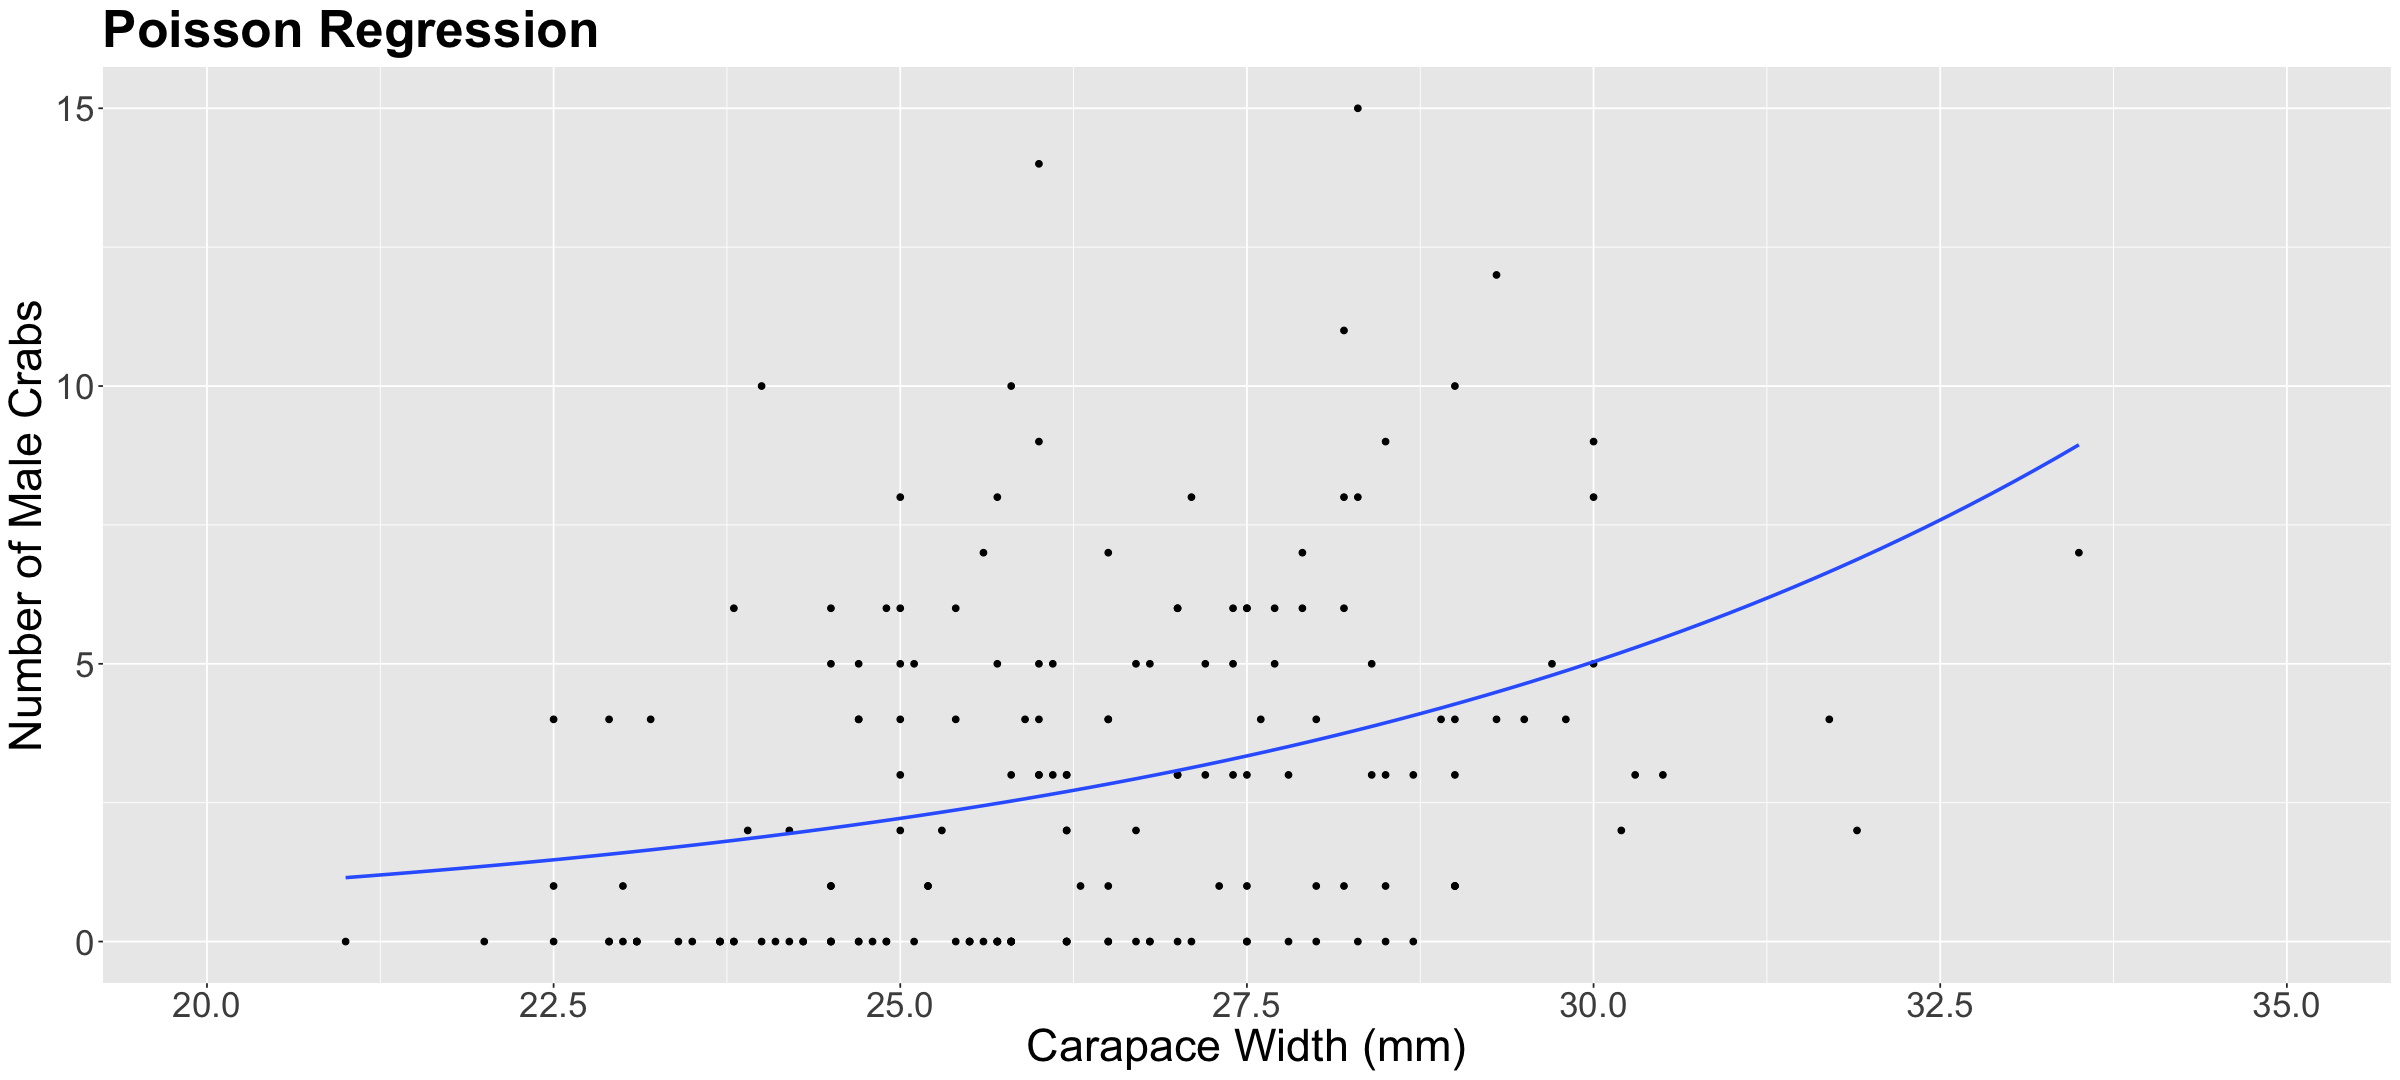

In [15]:
plot_crabs_vs_width <- plot_crabs_vs_width +
  geom_smooth(
    data = crabs, aes(width, n_males),
    method = "glm", formula = y ~ x,
    method.args = list(family = poisson), se = FALSE
  ) +
  ggtitle("Poisson Regression")
plot_crabs_vs_width

The blue line in the plot above is the fitted Poisson regression of `n_males` versus carapace `width`. The positive relationship is now clear with this regression line.

### 2.6. Coefficient Interpretation

Let us fit a second model with two regressors: `width` ($X_{\texttt{width}_i}$) and `color` ($X_{\texttt{color_darker}_i}$, $X_{\texttt{color_light}_i}$, and $X_{\texttt{color_medium}_i}$) for the $i$th observation:

$$
h(\lambda_i) = \log (\lambda_i) = \beta_0 + \beta_1 X_{\texttt{width}_i} + \beta_2 X_{\texttt{color_darker}_i} + \beta_3 X_{\texttt{color_light}_i} + \beta_4 X_{\texttt{color_medium}_i}.
$$

The explanatory variable `color` is of **factor-type** (**discrete**) and **nominal** (its levels do not follow any specific order). Moreover, it has a baseline: `dark`. **We can check the baseline level, via `levels()`, which is on the left-hand side.**

In [16]:
levels(crabs$color)

[1] "dark"   "darker" "light"  "medium"

Using explanatory variables such as `color` involves using **dummy variables** shown in [**this table**](https://pages.github.ubc.ca/MDS-2022-23/DSCI_562_regr-2_students/notes/lecture1_glm_logistic_regression.html#dummy-var), such as in Binary Logistic regression. For example, the explanatory variable `color` has four levels; thus, this Poisson regression model will incorporate three dummy variables: $X_{\texttt{color_darker}_i}$, $X_{\texttt{color_light}_i}$, and $X_{\texttt{color_medium}_i}$. Depending on the `color`, these dummy variables take on the following values:

- When `color` is `darker`, then $X_{\texttt{color_darker}_i} = 1$ while the other two dummy variables $X_{\texttt{color_light}_i} = X_{\texttt{color_medium}_i} = 0$.
- When `color` is `light`, then $X_{\texttt{light}_i} = 1$ while the other two dummy variables $X_{\texttt{color_darker}_i} = X_{\texttt{color_medium}_i} = 0$.
- When `color` is `medium`, then $X_{\texttt{medium}_i} = 1$ while the other two dummy variables $X_{\texttt{color_darker}_i} = X_{\texttt{color_light}_i} = 0$.

Note that the level `dark` is depicted as the baseline here. Hence, the interpretation of the coefficients in the model for each dummy variable will be to this baseline.

Now, let us fit this second Poisson regression model:

In [17]:
poisson_model_2 <- glm(n_males ~ width + color, family = poisson, data = crabs)
tidy(poisson_model_2, conf.int = TRUE) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-3.086,0.557,-5.536,0.000,-4.178,-1.993
width,0.149,0.021,7.166,0.000,0.108,0.190
colordarker,-0.011,0.180,-0.061,0.951,-0.373,0.336
colorlight,0.436,0.176,2.474,0.013,0.083,0.776
colormedium,0.237,0.118,2.003,0.045,0.009,0.473


We can see that `width`, `colorlight`, and `colormedium` are significant according to the `p.value` column (with $\alpha = 0.05$).

First, let us focus on the coefficient corresponding to carapace `width`, **while keeping `color` constant**. Consider an observation with a given value $X_{\texttt{width}} = \texttt{w}$ mm, and another observation with a given $X_{\texttt{width + 1}} = \texttt{w} + 1$ mm (i.e., an increase of $1$ mm). Then we have their corresponding regression equations:

```{math}
\begin{gather*}
\log \left( \lambda_{\texttt{width}} \right) = \beta_0 + \beta_1 \overbrace{\texttt{w}}^{X_{\texttt{width}}} + \overbrace{\beta_2 X_{\texttt{color_darker}} + \beta_3 X_{\texttt{color_light}} + \beta_4 X_{\texttt{color_medium}}}^{\text{Constant}} \\
\log \left( \lambda_{\texttt{width + 1}} \right) = \beta_0 + \beta_1 \underbrace{(\texttt{w} + 1)}_{X_{\texttt{width + 1}}} + \underbrace{\beta_2 X_{\texttt{color_darker}} + \beta_3 X_{\texttt{color_light}} + \beta_4 X_{\texttt{color_medium}}.}_{\text{Constant}}
\end{gather*}
```

We take the difference between both equations as:

```{math}
\begin{align*}
\log \left( \lambda_{\texttt{width + 1}} \right) - \log \left( \lambda_{\texttt{width1}} \right) &= \beta_1 (\texttt{w} + 1) - \beta_1 \texttt{w} \\
&= \beta_1.
\end{align*}
```

We apply the logarithm property for a ratio:

```{math}
\begin{align*}
\log \left( \frac{\lambda_{\texttt{width + 1}} }{\lambda_{\texttt{width}}} \right) &= \log \left( \lambda_{\texttt{width + 1}} \right) - \log \left( \lambda_{\texttt{width}} \right) \\
&= \beta_1.
\end{align*}
```

Finally, we have to exponentiate the previous equation:

$$
\frac{\lambda_{\texttt{width + 1}} }{\lambda_{\texttt{width}}} = e^{\beta_1}.
$$

The expression $\frac{\lambda_{\texttt{width + 1}} }{\lambda_{\texttt{width}}} = e^{\beta_1}$ indicates that the response varies in a **multiplicative way** when increased 1 mm in carapace `width`.

Therefore, by using the estimate $\hat{\beta}_1$ (note the hat notation) coming from the model `poisson_model_2`, we calculate this multiplicative effect as follows (via `exponentiate = TRUE` in `tidy()`):

In [18]:
tidy(poisson_model_2, exponentiate = TRUE, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.05,0.56,-5.54,0.00,0.02,0.14
width,1.16,0.02,7.17,0.00,1.11,1.21
colordarker,0.99,0.18,-0.06,0.95,0.69,1.40
colorlight,1.55,0.18,2.47,0.01,1.09,2.17
colormedium,1.27,0.12,2.00,0.05,1.01,1.60


$\frac{\hat{\lambda}_{\texttt{width + 1}} }{\hat{\lambda}_{\texttt{width}}} = e^{\hat{\beta}_1} = 1.16$ indicates that **the mean count of male crabs (`n_males`) around a female breeding nest** increases by $16\%$ when increasing the carapace `width` by $1$ mm, **while keeping `color` constant**. 

The interpretation of the significant coefficients corresponding to `color` (`colorlight` and `colormedium` with $\alpha = 0.05$) is associated to the baseline level `dark`.

Consider two observations, one with `dark` `color` of the prosoma (the baseline) and another with `light` `color`. Their corresponding responses are denoted as $\lambda_{\texttt{D}}$ (for `dark`) and $\lambda_{\texttt{L}}$ (for `light`). While holding $X_{\texttt{width}}$ constant, their regression equations are:

```{math}
\begin{gather*}
\log \left( \lambda_{\texttt{D}} \right) = \beta_0 + \overbrace{\beta_1 X_{\texttt{width}}}^{\text{Constant}} + \beta_2 X_{\texttt{color_darker}_{\texttt{D}}} + \beta_3 X_{\texttt{color_light}_{\texttt{D}}} + \beta_4 X_{\texttt{color_medium}_{\texttt{D}}} \\
\log \left( \lambda_{\texttt{L}} \right) = \beta_0 + \underbrace{\beta_1 X_{\texttt{width}}}_{\text{Constant}} + \beta_2 X_{\texttt{color_darker}_{\texttt{L}}} + \beta_3 X_{\texttt{color_light}_{\texttt{L}}} + \beta_4 X_{\texttt{color_medium}_{\texttt{L}}}
\end{gather*}
```

The corresponding `color` indicator variables for both $\lambda_{\texttt{D}}$ and $\lambda_{\texttt{L}}$ take on these values:

```{math}
\begin{align*}
\log \left( \lambda_{\texttt{D}} \right) &= \beta_0 + \overbrace{\beta_1 X_{\texttt{width}}}^{\text{Constant}} + \beta_2 X_{\texttt{color_darker}_{\texttt{D}}} + \beta_3 X_{\texttt{color_light}_{\texttt{D}}} + \beta_4 X_{\texttt{color_medium}_{\texttt{D}}} \\
&= \beta_0 + \beta_1 X_{\texttt{width}}+ \beta_2 \times 0 + \beta_3 \times 0 + \beta_4 \times 0 \\
&= \beta_0 + \beta_1 X_{\texttt{width}}
\end{align*}
```

```{math}
\begin{align*}
\log \left( \lambda_{\texttt{L}} \right) &= \beta_0 + \beta_1 X_{\texttt{width}} + \beta_2 X_{\texttt{color_darker}_{\texttt{L}}} + \beta_3 X_{\texttt{color_light}_{\texttt{L}}} + \beta_4 X_{\texttt{color_medium}_{\texttt{L}}} \\
&= \beta_0 + \beta_1 X_{\texttt{width}}+ \beta_2 \times 0 + \beta_3 \times 1 + \beta_4 \times 0 \\
&= \beta_0 + \underbrace{\beta_1 X_{\texttt{width}}}_{\text{Constant}} + \beta_3.
\end{align*}
```

Therefore, **what is the association of the level `light` with respect to `dark`?** Let us take the differences again:

```{math}
\begin{align*}
\log \left( \frac{\lambda_{\texttt{L}} }{\lambda_{\texttt{D}}} \right) &= \log \left( \lambda_{\texttt{L}} \right) - \log \left( \lambda_{\texttt{D}} \right) \\
&= \beta_3.
\end{align*}
```

Then, we exponentiate the previous equation:

$$
\frac{\lambda_{\texttt{L}} }{\lambda_{\texttt{D}}} = e^{\beta_3}.
$$

The expression $\frac{\lambda_{\texttt{L}} }{\lambda_{\texttt{D}}} = e^{\beta_3}$ indicates that the response varies in a **multiplicative way** when the `color` of the prosoma changes from `dark` to `light`.

Therefore, by using the estimate $\hat{\beta}_3$ (note the hat notation) coming from the model `poisson_model_2`, we calculate this multiplicative effect as follows (via `exponentiate = TRUE` in `tidy()`)::

In [19]:
tidy(poisson_model_2, exponentiate = TRUE, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.05,0.56,-5.54,0.00,0.02,0.14
width,1.16,0.02,7.17,0.00,1.11,1.21
colordarker,0.99,0.18,-0.06,0.95,0.69,1.40
colorlight,1.55,0.18,2.47,0.01,1.09,2.17
colormedium,1.27,0.12,2.00,0.05,1.01,1.60


$\frac{\hat{\lambda}_{\texttt{L}} }{\hat{\lambda}_{\texttt{D}}} = e^{\hat{\beta}_3} = 1.55$ indicates that **the mean count of male crabs (`n_males`) around a female breeding nest** increases by $55\%$ when the `color` of the prosoma changes from `dark` to `light`, **while keeping the carapace `width` constant**.

### 2.7. Predictions

Suppose we want to predict **the mean count of male crabs (`n_males`) around a female breeding nest** with a carapace `width` of $27.5$ mm and `light` `color` of the prosoma. We could use the model `poisson_model_2` for making such prediction as follows:

In [20]:
round(predict(poisson_model_2, tibble(width = 27.5, color = "light"),
  type = "response"
), 2)

1 
4.29

Note we have to use `type = "response"` in the function `predict()` to obtain the prediction **on its original scale**.

### 2.8. Model Selection

We can also use the analysis of deviance to perform model selection between two Poisson models where one is nested in the other. Moreover, we can use this analysis to perform a **goodness of fit test**.

#### 2.8.1. Goodness of Fit Test

First, recall deviance $D_p$ is used to compare a given model with $p$ regressors with that of a baseline model. The usual baseline model is the **saturated model**, which perfectly fits the data because it allows a distinct Poisson mean $\lambda_i$ for the $i$th observation in the dataset ($i = 1, \dots, n$), **unrelated to the $p$ regressors**.

The maximized likelihood of the full model is denoted as $\hat{\mathscr{l}}_f$, whereas $\hat{\mathscr{l}}_p$ is the value of the maximized likelihood computed from our dataset of $n$ observation with $p$ regressors. We compare the fits provided by these two models by the deviance $D_p$ given by

$$
D_p = -2 \log \Bigg(\frac{\hat{\mathscr{l}}_p}{\hat{\mathscr{l}}_f} \Bigg) =  -2 \left[ \log \left( \hat{\mathscr{l}}_p \right) - \log \left(\hat{\mathscr{l}}_f \right) \right].
$$

Specifically, for Poisson regression, $D_p$ is defined as follows:

```{math}
:label: deviance-poisson
\begin{gather}
\hat{\lambda}_i = \exp{\left( \hat{\beta_0} + \hat{\beta}_1 x_{i,1} + \dots + \hat{\beta}_p x_{i,p} \right)} \\
D_p = 2 \sum_{i = 1}^n \left[ y_i \log \left( \frac{y_i}{\hat{\lambda}_i} \right) - \left( y_i - \hat{\lambda}_i \right) \right]
\end{gather}
```

where $y_i$ is the $i$th observed response in the training set of size $n$. Note that when $y_i = 0$ counts, then $\log \left( \frac{y_i}{\hat{\lambda}_i} \right)$ is assumed as $0$.

Unlike {eq}`deviance-bin-log` in Binary Logistic regression, {eq}`deviance-poisson` depicts the agreement of our model with $p$ regressors to the observed data. Hence, we can use {eq}`deviance-poisson` to test the goodness of fit; i.e., **whether our fitted model fits the data better than the saturated model, which makes it correctly specified (with a level of significance $\alpha$!)**.

The hypothesis are the following:

```{math}
\begin{gather*}
H_0: \text{Our}\textbf{ Model with $p$ regressors} \text{ fits the data better than the } \textbf{Saturated Model} \\
H_a: \text{otherwise.}
\end{gather*}
```

Let us test our following `poisson_model_1`:

$$h(\lambda_i) = \log(\lambda_i) = \beta_0 + \beta_1 X_{\texttt{width}_i}.$$

We cannot use `anova()`, as in the nesting case, to perform this hypothesis testing. We will have to do it manually via `glance()`,

In [21]:
summary_poisson_model_1 <- glance(poisson_model_1)
summary_poisson_model_1

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
632.7917,172,-461.5881,927.1762,933.4828,567.8786,171,173


Column `deviance` provides $D_p$ and is formally called **residual deviance**. **Asymptotically**, we have the following **null distribution**:

$$
\Delta_p \sim \chi^2_{n - (p + 1)}.
$$

The degrees of freedom (column `df.residual` in our `glance()` output) are the **difference between the training set size $n$ and the number of regression parameters in our model (including the intercept $\beta_0$).**

Let us obtain the corresponding $p\text{-value}$ for this test. We can do it using `pchisq()`:

In [22]:
pchisq(summary_poisson_model_1$deviance,
  df = summary_poisson_model_1$df.residual,
  lower.tail = FALSE
)

[1] 4.490964e-44

We obtain a $p\text{-value} < .001$, which gives statistical evidence to state that our `poisson_model` is correctly specified when compared to the saturated model.

#### 2.8.2. Analysis of Deviance for Nested Models

As in the case of Binary logistic regression, we can use analysis of deviance for model selection when two models are nested. We will test our two models: `poisson_model_1` with carapace `width` as a explanatory variable, which is nested in `poisson_model_2` with carapace `width` and the `color` of the prosoma as explanatory variables.

```{math}
\begin{align*}
\textbf{Model 1:} & \\ 
& h(\lambda_i) = \log(\lambda_i) = \beta_0 + \beta_1 X_{\texttt{width}_i}. \\
\textbf{Model 2:} & \\ 
& h(\lambda_i) = \log(\lambda_i) = \beta_0 + \beta_1 X_{\texttt{width}_i} + \beta_2 X_{\texttt{color_darker}_i} + \beta_3 X_{\texttt{color_light}_i} + \beta_4 X_{\texttt{color_medium}_i}. \\
\end{align*}
```

This specific model selection will involve a hypothesis testing. The hypotheses are:

```{math}
\begin{gather*}
H_0: \textbf{Model 1} \text{ fits the data better than } \textbf{Model 2} \\
H_a: \text{otherwise.}
\end{gather*}
```

Again, we use the multipurpose function `anova()` in the following way:

In [23]:
round(anova(poisson_model_1,
  poisson_model_2,
  test = "Chi"
), 4)

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,171,567.8786,NA,NA,NA
2,168,559.3448,3,8.5338,0.0362


Let $D_2$ be the deviance (column `Resid. Dev`) for **Model 2** (`poisson_model_2`) in row 2 and $D_1$ (column `Resid. Dev`) the deviance for **Model 1** (`poisson_model_1`) in row 1. The test statistic $\Delta_D$ (column `Deviance`) for the analysis of deviance is given by:

$$
\Delta_D = D_1 - D_2 \sim \chi^2_{3},
$$

which **asymptotically** (i.e., $n \rightarrow \infty$) is chi-squared distributed with $3$ degrees of freedom (column `Df`) under $H_0$ **for this specific case**. In general, the degrees of freedom are the **regression parameters of difference between both models** (this has an impact on the factor-type explanatory variables with more than one dummy variable). Recall this is called the **likelihood-ratio test**.

We obtain a $p\text{-value} < .05$, column `Pr(>Chi)`, which gives us evidence to reject $H_0$ with $\alpha = 0.05$. Hence, we do not have evidence to conclude that `poisson_model_1` fits the data better than `poisson_model_2`. In the context of model selection, we would choose `poisson_model_2`, that also includes the `color` of the prosoma.

#### 2.8.3. AIC and BIC

AIC {eq}`aic` and BIC {eq}`bic` can also be used for model selection as follows:

In [24]:
glance(poisson_model_1) %>% mutate_if(is.numeric, round, 3)

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
632.792,172,-461.588,927.176,933.483,567.879,171,173


In [25]:
glance(poisson_model_2) %>% mutate_if(is.numeric, round, 3)

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
632.792,172,-457.321,924.642,940.409,559.345,168,173


Following the results of the `AIC` column, we choose `poisson_model_2` over `poisson_model_1`. Nonetheless, the `BIC` is penalizing the `poisson_model_2` for having more model parameters, so `poisson_model` would be chosen using this criterion.

## 3. Overdispersion

From **DSCI 551**, we know that population variances of some random variables are **in function** of their respective means. For instance:

- If $X \sim \text{Exponential}(\lambda)$, then $\mathbb{E}(X) = \lambda$ and $\text{Var}(X) = \lambda^2$.
- If $X \sim \text{Binomial}(n , \pi)$, then $\mathbb{E}(X) = n \pi$ and $\text{Var}(X) = n \pi (1 - \pi)$.
- If $X \sim \text{Poisson}(\lambda)$, then $\mathbb{E}(X) = \lambda$ and $\text{Var}(X) = \lambda$.

Now, you might wonder: **how does equidispersion affect our Poisson regression model?**

First, we must clarify that GLMs naturally deal with some types of **heteroscedasticity** (inequality of variances across the responses). For example, note that each observation $i = 1, \dots, n$ in our training set (used to estimate a Poisson regression model) is assumed as:

$$Y_i \sim \text{Poisson}(\lambda_i),$$

where the indexed parameter $\lambda_i$ makes the model flexible enough to deal with heteroscedasticity. Moreover, the larger $\lambda_i$ is, the larger the variance per observation will be.

Let us make a quick simulation on this matter. The code below creates ten samples of $n = 1000$ each from different Poisson populations with an increasing variance $\lambda$.

In [26]:
set.seed(562)

poisson_samples <- tibble(x = -1, lambda = 0)

for (lambda in seq(1, 91, 10)) {
  sample <- rpois(1000, lambda)
  poisson_samples <- poisson_samples %>% bind_rows(tibble(
    x = sample,
    lambda = lambda
  ))
}

poisson_samples <- poisson_samples %>% filter(x != -1)

The side-by-side jitter plots below illustrate the impact of an increasing variance in each of the ten Poisson populations, where each set of $n = 1000$ data points gets more and more spread out. We see the same trend with the side-by-side boxplots.

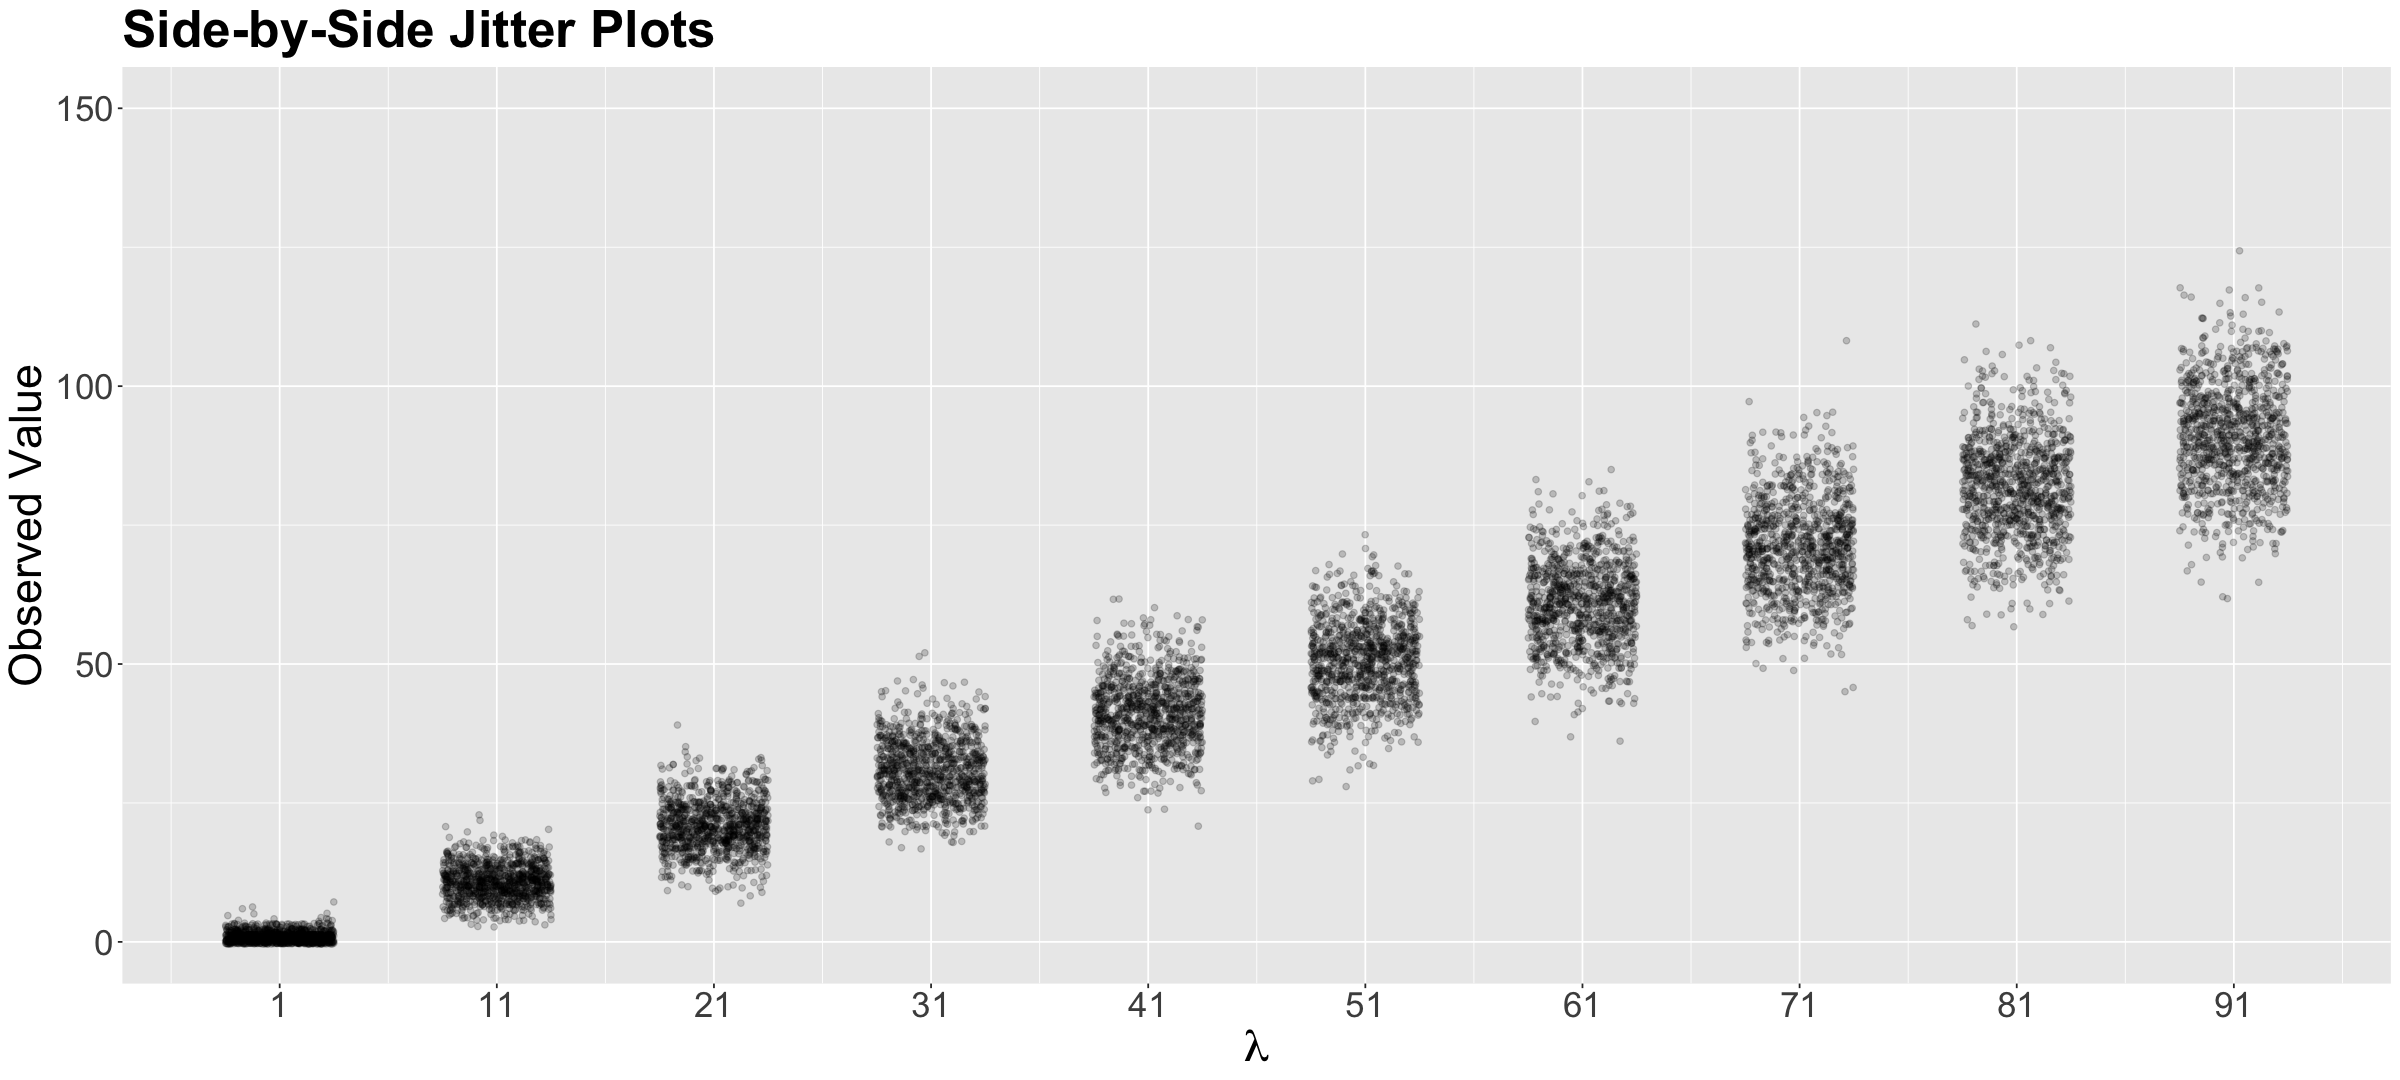

In [27]:
poisson_jitter_plots <- poisson_samples %>%
  ggplot(aes(lambda, x)) +
  geom_jitter(alpha = .2, width = 2.5) +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27)
  ) +
  coord_cartesian(ylim = c(0, 150)) +
  labs(y = "Observed Value") +
  ggtitle("Side-by-Side Jitter Plots") +
  scale_x_continuous(breaks = seq(1, 91, 10)) + 
  labs(x = expression(lambda))
poisson_jitter_plots

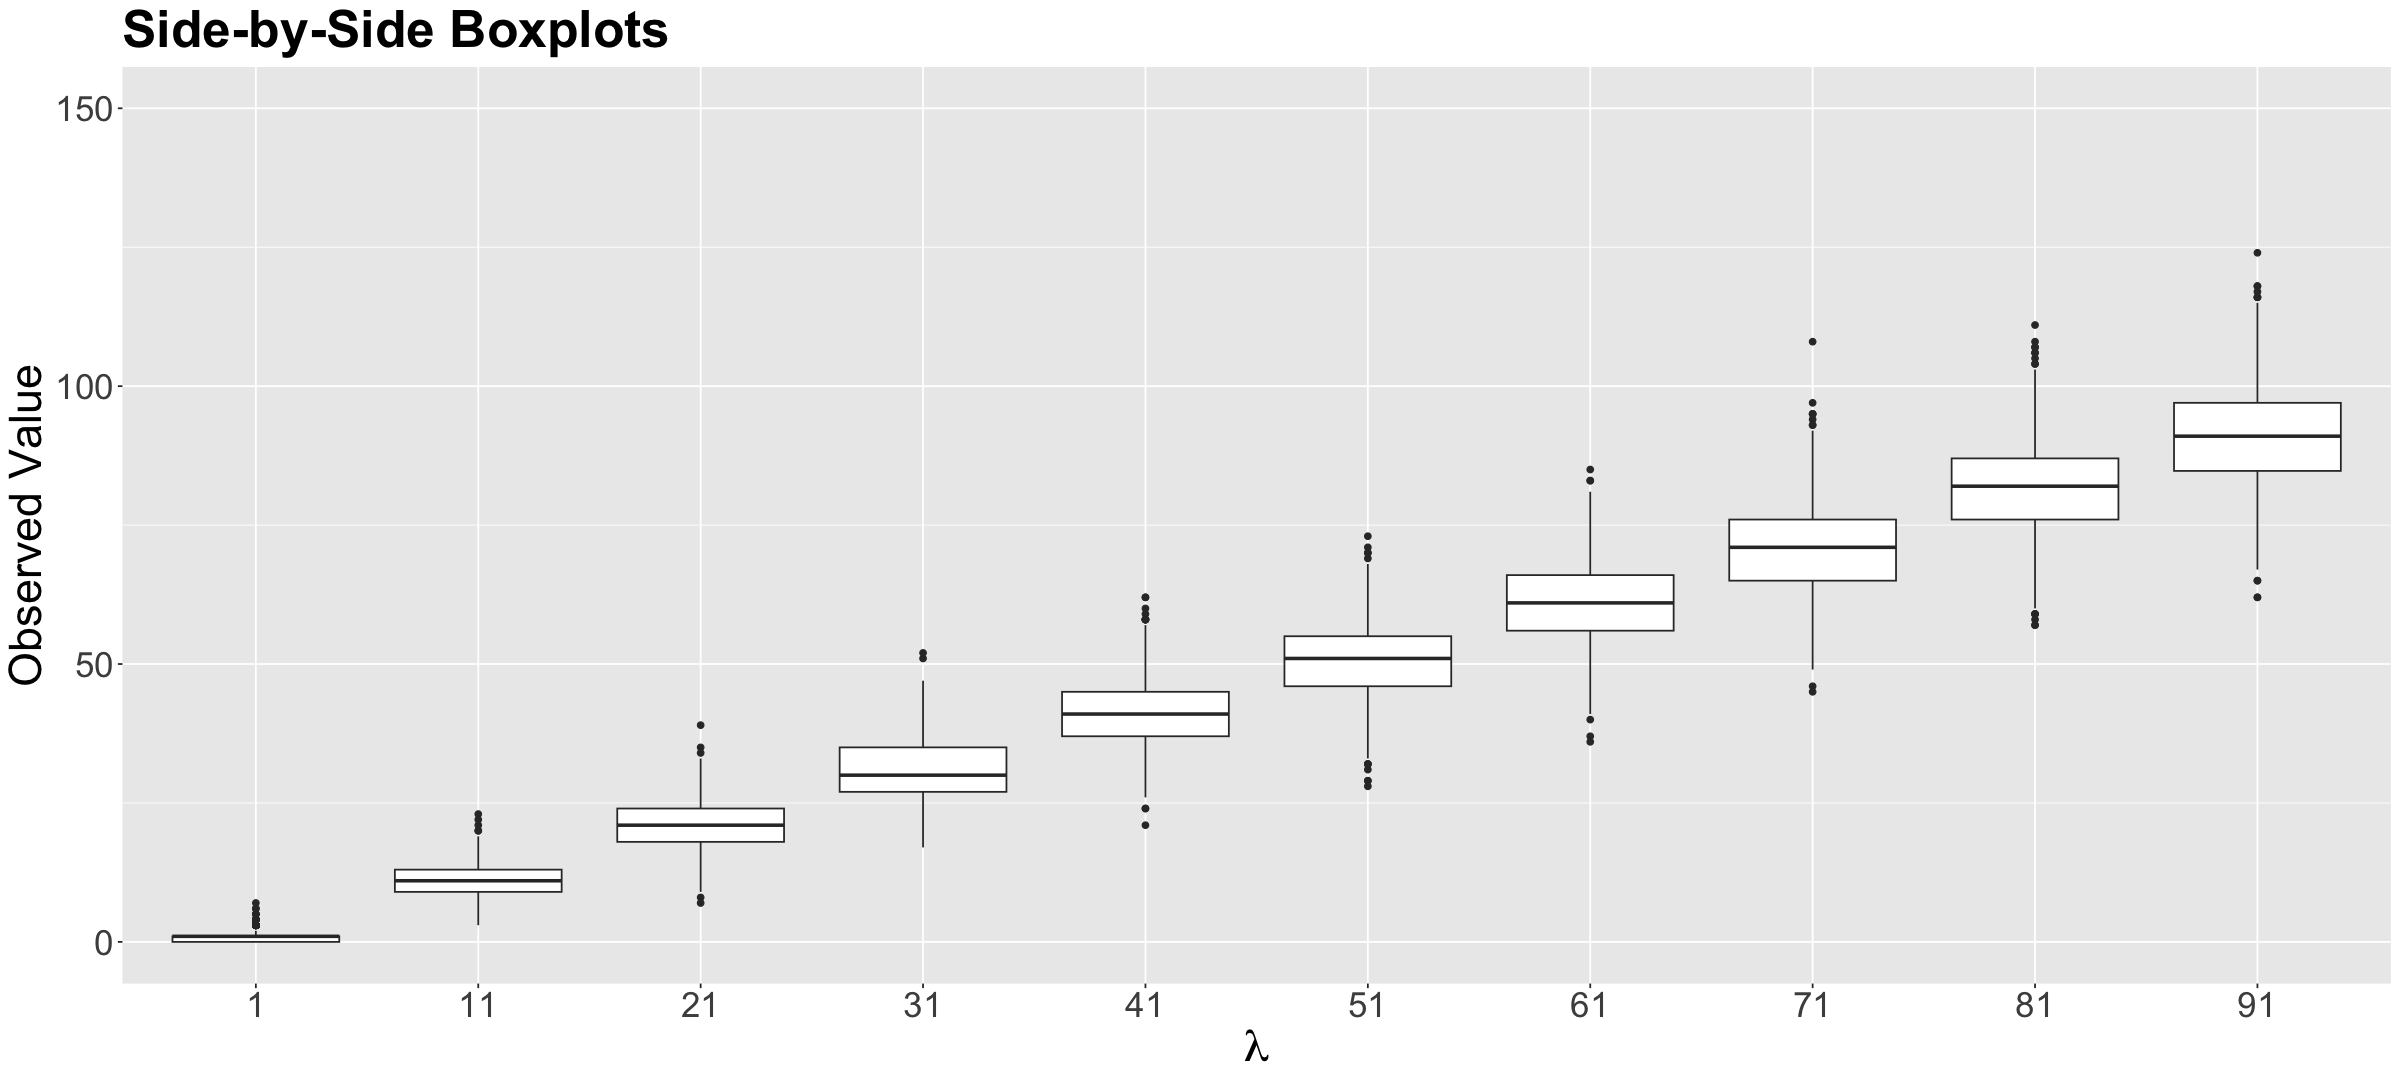

In [28]:
poisson_boxplots <- poisson_samples %>%
  ggplot(aes(x = as_factor(lambda), y = x)) + 
  geom_boxplot() +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27)
  ) +
  coord_cartesian(ylim = c(0, 150)) +
  labs(y = "Observed Value", x = "lambda") +
  ggtitle("Side-by-Side Boxplots") + 
  labs(x = expression(lambda))
poisson_boxplots

We already defined **equidispersion** as an important characteristic of a Poisson random variable. We already explained that this random variable has the same mean and variance. The mean is the average of values in our dataset. Variance measures how spread the data are. It is computed as the average of the squared differences from the mean. A variance will be equal to zero if all values in our dataset are identical. The greater the difference between the values, the greater the variance.

From the below plot, note that the relationship of the **sample variance** in these samples is practically linear to the population $\lambda$. So this is what equidispersion graphically looks like.

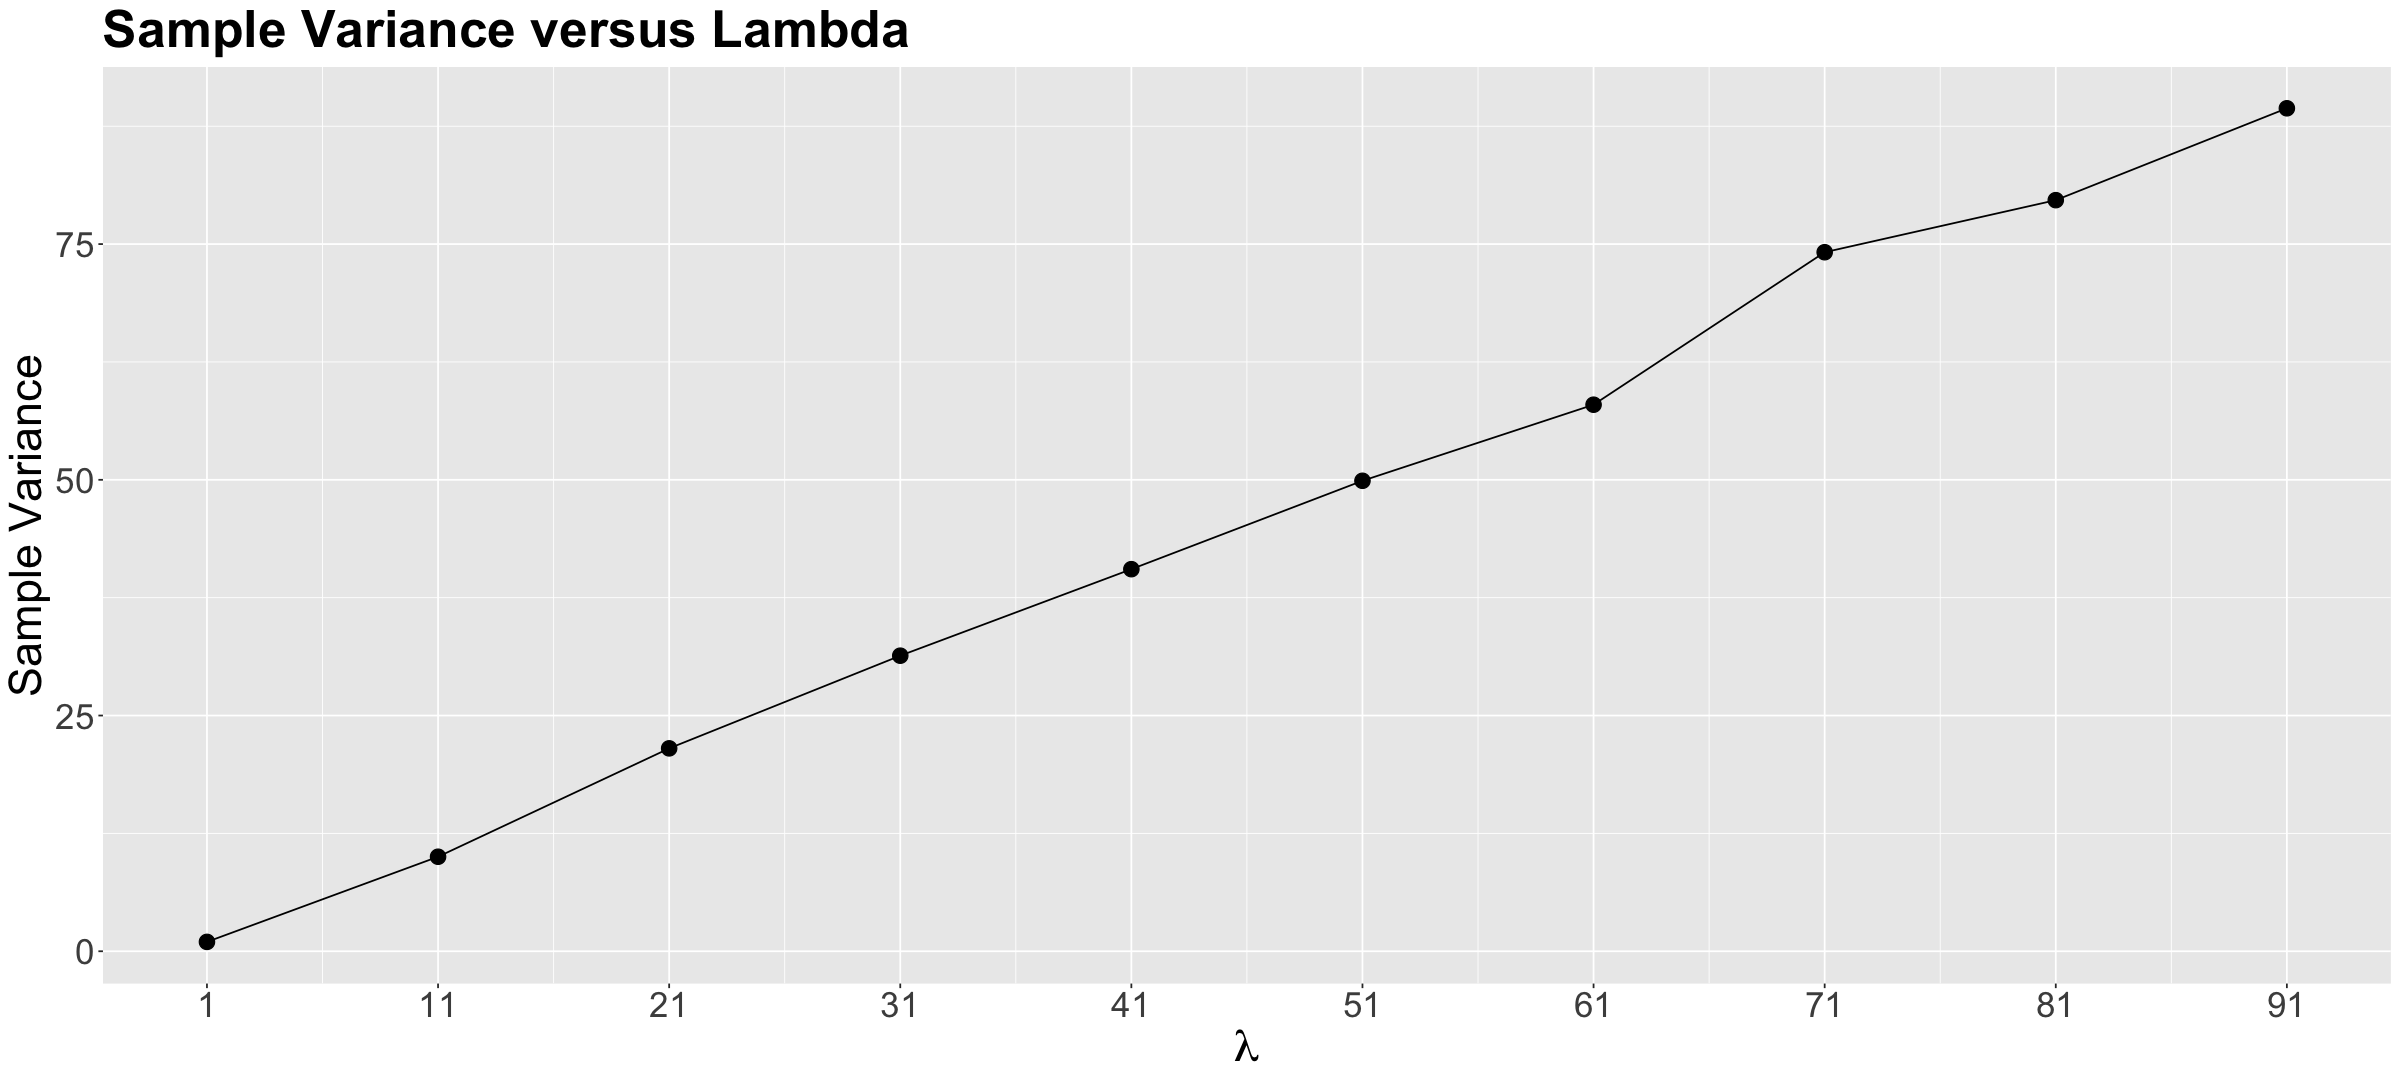

In [29]:
suppressWarnings(suppressMessages(print(poisson_samples %>% group_by(lambda) %>%
  summarise(sample_variance = var(x)) %>%
  ggplot() +
  geom_line(aes(lambda, sample_variance)) +
  geom_point(aes(lambda, sample_variance), size = 4) +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27)
  ) +
  labs(y = "Sample Variance", x = expression(lambda)) +
  ggtitle("Sample Variance versus Lambda") +
  scale_x_continuous(breaks = seq(1, 91, 10)))))

Having said all this, in many cases, the variance of our data is sometimes larger than the variance considered by our model **as in the basic Poisson regression**.

```{important}
When the variance is larger than the mean in a random variable, we have **overdispersion**. This matter will impact the standard error of our parameter estimates in a basic Poisson regression, as we will see.
```

Let us go back to our `poisson_model_1` with the log link function from the `crabs` dataset with `width` as a regressor:

$$
h(\lambda_i) = \log(\lambda_i) = \beta_0 + \beta X_{\texttt{width}_i}.
$$

In [30]:
summary(poisson_model_1)


Call:
glm(formula = n_males ~ width, family = poisson, data = crabs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8526  -1.9884  -0.4933   1.0970   4.9221  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.30476    0.54224  -6.095  1.1e-09 ***
width        0.16405    0.01997   8.216  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 632.79  on 172  degrees of freedom
Residual deviance: 567.88  on 171  degrees of freedom
AIC: 927.18

Number of Fisher Scoring iterations: 6


We will test whether there is overdispersion in this Poisson regression model via function `dispersiontest()`, (from package `AER`). 

Let $Y_i$ be the $i$th Poisson response in the count regression model. **Ideally in the presence of equidispersion**, $Y_i$ has the following parameters:

```{math}
\begin{gather*}
\mathbb{E}(Y_i) = \lambda_i \\
\text{Var}(Y_i) = \lambda_i.
\end{gather*}
```

The test uses the following mathematical expression:

$$
\text{Var}(Y_i) = \overbrace{(1 + \gamma)}^\text{Dispersion Factor} \lambda_i,
$$

with the hypotheses

```{math}
\begin{gather*}
H_0: 1 + \gamma = 1 \\
H_a: 1 + \gamma > 1.
\end{gather*}
```

When there is evidence of overdispersion in our data, **we will reject $H_0$**.

In [31]:
dispersiontest(poisson_model_1)


	Overdispersion test

data:  poisson_model_1
z = 5.558, p-value = 1.364e-08
alternative hypothesis: true dispersion is greater than 1
sample estimates:
dispersion 
  3.157244 


With $\alpha = 0.05$, we reject $H_0$ since the $p\text{-value} < .001$. Hence, the `poisson_model_1` has overdispersion.

## 4. Quasi-Poisson Regression

One of the consequences of having overdispersion in our model is that **our standard errors will be underestimated**, which will have an impact if we want to use the model to make inference. An underestimated standard error will make us **more prone to reject the null hypothesis even though it might be true** (**i.e., committing Type I error**).

Alternatively to a Poisson regression model, we can use Quasi-Poisson:

- We still assume the following mean for the $i$th response as

```{math}
:label: quasi-mean
\begin{equation}
\mathbb{E}(Y_i) = \lambda_i.
\end{equation}

```

- This regression model allows the regular variance value to be multiplied by an **overdisperdion factor** $\theta$ as

```{math}
:label: quasi-variance
\begin{equation}
\text{Var}(Y_i) = \theta \lambda_i.
\end{equation}
```

- Also, note that using the Quasi-Poisson **does not change the estimates, just the standard errors**.
- Finally, **we cannot get the AIC or BIC using a Quasi-Poisson, because there is no regular likelihood function for this method**.

```{admonition} A note on Quasi-Poisson estimation
Unlike the Poisson regression models, Quasi-Poisson is not a maximum likelihood approach but **quasi-likelihood**. Roughly speaking, a quasi-likelihood approach **does not assume a fully joint probability distribution** on our training data to construct a likelihood function so we can estimate the regression parameters (as in **Exercise 1** in `lab1`). Instead, Quasi-Poisson only assumes a relationship between the mean and variance as in {eq}`quasi-mean` and {eq}`quasi-variance` to build a quasi-likelihood function $Q$ whose algebraic properties are similar to a regular likelihood function.

Nevertheless, this approach computes differently each standard error $\mbox{se}(\hat{\beta}_j)$ (used for testing the significance of a regression coefficient $\beta_j$ associated with the $j$th regressor). This computation considers that there is overdispersion in the data, but how is it possible? The answer lies in an overdispersion parameter $\theta$ representing this extra variance in our data. Hence, $\theta$ quantifies how much variance is larger than the mean as a scale factor and lets the model provide a better fitting.
```

To fit this model, we use the function `glm()` and its argument `family = quasipoisson` (required to specify the Quasi-Poisson model).

In [32]:
quasi_poisson_model <- glm(n_males ~ width, family = quasipoisson, data = crabs)
summary(quasi_poisson_model)


Call:
glm(formula = n_males ~ width, family = quasipoisson, data = crabs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8526  -1.9884  -0.4933   1.0970   4.9221  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.30476    0.96729  -3.417 0.000793 ***
width        0.16405    0.03562   4.606 7.99e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasipoisson family taken to be 3.182205)

    Null deviance: 632.79  on 172  degrees of freedom
Residual deviance: 567.88  on 171  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 6


Via `summary()`, we can see that the estimated overdispersion factor $\hat{\theta} = 3.18$.

In [33]:
summary(poisson_model_1)


Call:
glm(formula = n_males ~ width, family = poisson, data = crabs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8526  -1.9884  -0.4933   1.0970   4.9221  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.30476    0.54224  -6.095  1.1e-09 ***
width        0.16405    0.01997   8.216  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 632.79  on 172  degrees of freedom
Residual deviance: 567.88  on 171  degrees of freedom
AIC: 927.18

Number of Fisher Scoring iterations: 6


If we compare `quasi_poisson_model` to `poisson_model_1`, the standard errors in `quasi_poisson_model` are larger than in `poisson_model_1`. Given that we already concluded that there was overdispersion in `poisson_model_1`, we can conclude that we are underestimating the standard errors. Hence, the `quasi_poisson_model` provides more reliable inferential conclusions.

## 5. Negative Binomial Regression

Let

$$Y_i \sim \text{Negative Binomial} (k, \pi_i) \quad \text{for} \quad i = 1, \dots, n.$$

From **DSCI 551's** [**`lecture2`**](https://pages.github.ubc.ca/MDS-2022-23/DSCI_551_stat-prob-dsci_students/parametric-families.html#negative-binomial-a.k.a.-pascal), recall that a Negative Binomial distribution has the following probability mass function (PMF):

```{math}
:label: nb-pdf
\begin{equation}
P(Y_i = y_i \mid k, \pi_i) = {k - 1 + y_i \choose y_i} \pi_i^{k} (1 - \pi_i)^{y_i}  \quad \text{for} \quad y_i = 0, 1, \dots
\end{equation}
```

A Negative Binomial random variable depicts **the number of $y_i$ failed independent Bernoulli trials before experiencing $k$ successes** with a probability of success $\pi_i$.

This distribution has the following mean and variance:

```{math}
\begin{gather*}
\mathbb{E}(Y_i) = \frac{k(1 - \pi_i)}{\pi_i} \\
\text{Var}(Y_i) = \frac{k(1 - \pi_i)}{\pi_i^2}.
\end{gather*}
```

### 5.1. Reparametrization 

Under the following parametrization:

```{math}
:label: nb-param
\begin{equation}
\lambda_i = \frac{k (1 - \pi_i)}{\pi_i} \qquad \Rightarrow \qquad \pi_i = \frac{k}{k + \lambda},
\end{equation}
```

the mean and variance can be reexpressed as

```{math}
:label: nb-mean-variance
\begin{gather}
\mathbb{E}(Y_i) = \lambda_i \\
\text{Var}(Y_i) = \lambda_i \left( 1 + \frac{\lambda_i}{k} \right).
\end{gather}
```

This reparametrized variance indicates that a Negative Binomial random variable allows for overdispersion through factor $\left( 1 + \frac{\lambda_i}{k} \right)$.

Finally, by applying parametrization {eq}`nb-param` in PDF {eq}`nb-pdf`, we have the following:

```{math}
:label: nb-alt-pdf
\begin{align}
P(Y_i = y_i \mid k, \pi_i) &= {k - 1 + y_i \choose y_i} \pi_i^{k} (1 - \pi_i)^{y_i} \\
&= \frac{(k + y_i - 1)!}{y_i! (k - 1 )!} \left( \frac{k}{k + \lambda} \right)^{k} \left( 1 - \frac{k}{k + \lambda} \right)^{y_i} \\
&= \frac{\Gamma(y_i + k)}{\Gamma(y_i + 1) \Gamma(k)} \left( \frac{k}{k + \lambda} \right)^{k} \left( 1 - \frac{k}{k + \lambda} \right)^{y_i},
\end{align}
```

where $\Gamma(\cdot)$ is the [**Gamma function**](https://www.statlect.com/mathematical-tools/gamma-function). We actually use the property 

$$\Gamma(a) = (a - 1)!,$$ 

where $a \geq 1$ is an integer.

```{admonition} Additional note
In **DSCI 551**, we highlighted the fact that some distributions converge to anothers where certain parameters tend to infinity. It can be shown that

$$X \sim \text{Poisson}(\lambda) = \lim_{k \to \infty} \text{Negative Binomial}(k, \pi).$$

**The proof is out of the scope of this course.**
```

### 5.2. General Modelling Framework

As in the case of Poissson regression with $p$ regressors, the Negative Binomial case is a GLM with the following link function:

```{math}
:label: nb-model
\begin{equation}
h(\lambda_i) = \log(\lambda_i) = \beta_0 + \beta_1 X_{i,1} + \dots + \beta_p X_{i,p}.
\end{equation}
```
Lastly, note the following: 

- From {eq}`nb-mean-variance`, let $\theta = \frac{1}{k}$. Then, Negative Binomial regression will assume the following variance:

```{math}
\begin{align*}
\text{Var}(Y_i) &= \lambda_i \left( 1 + \frac{\lambda_i}{k} \right) \\
&= \lambda_i + \frac{\lambda_i^2}{k} \\
&= \lambda_i + \theta \lambda_i^2.
\end{align*}
```
- **Therefore, the model has even more flexibility to deal with overdispersion compared to Quasi-Poisson regression.**

### 5.3. Estimation
  
Via a training set of size $n$ whose responses are **independent counts** $Y_i$ ($i = 1, \dots, n$), we use the reparametrized PMF {eq}`nb-alt-pdf` along with the link function {eq}`nb-model` along with **maximum likelihood estimation** to obtain $\hat{\beta}_0, \hat{\beta}_1, \dots, \hat{\beta}_p, \hat{\theta}$. The procedure is analogous to the one in **Exercise 1** in `lab1`.
  
To fit a Negative Binomial regression via `R`, we can use the function `glm.nb()` from package `MASS`.

In [34]:
library(MASS)


Attaching package: ‘MASS’


The following object is masked _by_ ‘.GlobalEnv’:

    crabs


The following object is masked from ‘package:dplyr’:

    select




In [35]:
negative_binomial_model <- glm.nb(n_males ~ width, data = crabs)
summary(negative_binomial_model)


Call:
glm.nb(formula = n_males ~ width, data = crabs, init.theta = 0.90456808, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7798  -1.4110  -0.2502   0.4770   2.0177  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.05251    1.17143  -3.459 0.000541 ***
width        0.19207    0.04406   4.360  1.3e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.9046) family taken to be 1)

    Null deviance: 213.05  on 172  degrees of freedom
Residual deviance: 195.81  on 171  degrees of freedom
AIC: 757.29

Number of Fisher Scoring iterations: 1


              Theta:  0.905 
          Std. Err.:  0.161 

 2 x log-likelihood:  -751.291 

Note that the output provides $\hat{\theta} = 0.905$ along with its standard error $\text{se}(\hat{\theta}) = 0.161$. Moreover, the standard errors of the other estimates are slightly larger than in `quasi_poisson_model`. Suppose we would like to be on the safe side with a regular maximum likelihood approach for our inferential conclusions while allowing for model selection. In that case, Negative Binomial regression is the way to go.

### 5.4. Coefficient Interpretation, Prediction, Goodness of Fit, and Model Selection

Since the link function in Negative Binomial regression is the same as in Poisson regression, coefficient interpretation and prediction are performed similarly (even with the same `R` functions!). Regarding model selection, since we use a regular maximum likelihood approach to estimate the regression parameters, we can use analysis of deviance, AIC, and BIC to perform model selection and/or goodness of fit testing.

## 6. Wrapping Up

Negative Binomial regression is even more flexible than the Quasi-Poisson case since the variance's representation allows it to be a quadratic function of the mean with an additional parameter. 

As we can see, the previous Quasi-Poisson and Negative Binomial regression models have extra parameters in the variance expression that allow us to construct a more accurate model for specific count data (since the mean and the variance do not need to be equal!). However, the variable association tests and conclusions are conducted similarly under these two models, as in the Poisson regression.

We have covered binary and count responses so far via GLMs to make inference. Nevertheless, is there any modelling option when the response is categorical (nominal or ordinal)?